# Generation and post-analysis in aids dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
from lifelines import CoxPHFitter
from tableone import TableOne
import importlib
import os 

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.util import Surv

from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.plugins import Plugins

from run_HIVAE import train_HIVAE, generate_from_HIVAE

from synthcity.metrics.eval import Metrics
from synthcity.metrics.scores import ScoreEvaluator
from synthcity.utils.reproducibility import clear_cache, enable_reproducible_results
from synthcity.metrics.plots import plot_tsne

warnings.filterwarnings("ignore")

%matplotlib inline

/opt/anaconda3/envs/env_synthcity/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


## Original data loading, analysis and visualization

### Experiment setting - links to data

In [2]:
dataset_name = "Aids"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
aids_control = pd.read_csv(data_file_control,header=None)
aids_control.columns = ["time", "censor", "strat2", "sex", "raceth", "ivdrug", "karnof", "cd4", "priorzdv", "age"]
aids_control.head() 

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
0,189,0,1,1,1,0,100,169.0,39.0,34
1,287,0,1,2,2,0,90,149.5,15.0,34
2,199,0,1,1,1,0,90,46.0,53.0,48
3,270,0,1,1,2,0,100,54.5,6.0,51
4,276,0,1,1,1,0,100,95.0,7.0,34


In [4]:
aids_control_columns = pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
aids_control_columns.insert(0, 'censor')
aids_control_columns.insert(0, 'time')
print(aids_control_columns)

['time', 'censor', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4', 'priorzdv', 'age']


In [5]:
# Load control data
data_control, feat_types_dict, miss_mask_control, true_miss_mask_control, n_samples_control = data_processing.read_data(data_file_control, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)
# One-hot encoding
data_transformed_control = data_processing.discrete_variables_transformation(data_control, feat_types_dict)

In [6]:
# Load treated data
data_treated, feat_types_dict, miss_mask_treated, true_miss_mask_treated, n_samples_treated = data_processing.read_data(data_file_treated, 
                                                                                                                        feat_types_file_treated, 
                                                                                                                        miss_file, true_miss_file)
# One-hot encoding 
data_transformed_treated = data_processing.discrete_variables_transformation(data_treated, feat_types_dict)

In [7]:
df_transformed_treated = pd.DataFrame(data_transformed_treated.numpy(), columns=aids_control_columns)
df_transformed_control = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_treated["treatment"] = 1
df_transformed_control["treatment"] = 0
df_transformed_all = pd.concat([df_transformed_control, df_transformed_treated], ignore_index=True)
print(df_transformed_all.shape)
df_transformed_all.head()

(1151, 11)


,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,treatment
0,189.0,0.0,1.0,0.0,0.0,0.0,3.0,169.0,39.0,34.0,0
1,287.0,0.0,1.0,1.0,1.0,0.0,2.0,149.5,15.0,34.0,0
2,199.0,0.0,1.0,0.0,0.0,0.0,2.0,46.0,53.0,48.0,0
3,270.0,0.0,1.0,0.0,1.0,0.0,3.0,54.5,6.0,51.0,0
4,276.0,0.0,1.0,0.0,0.0,0.0,3.0,95.0,7.0,34.0,0


comparison variable treatment 10


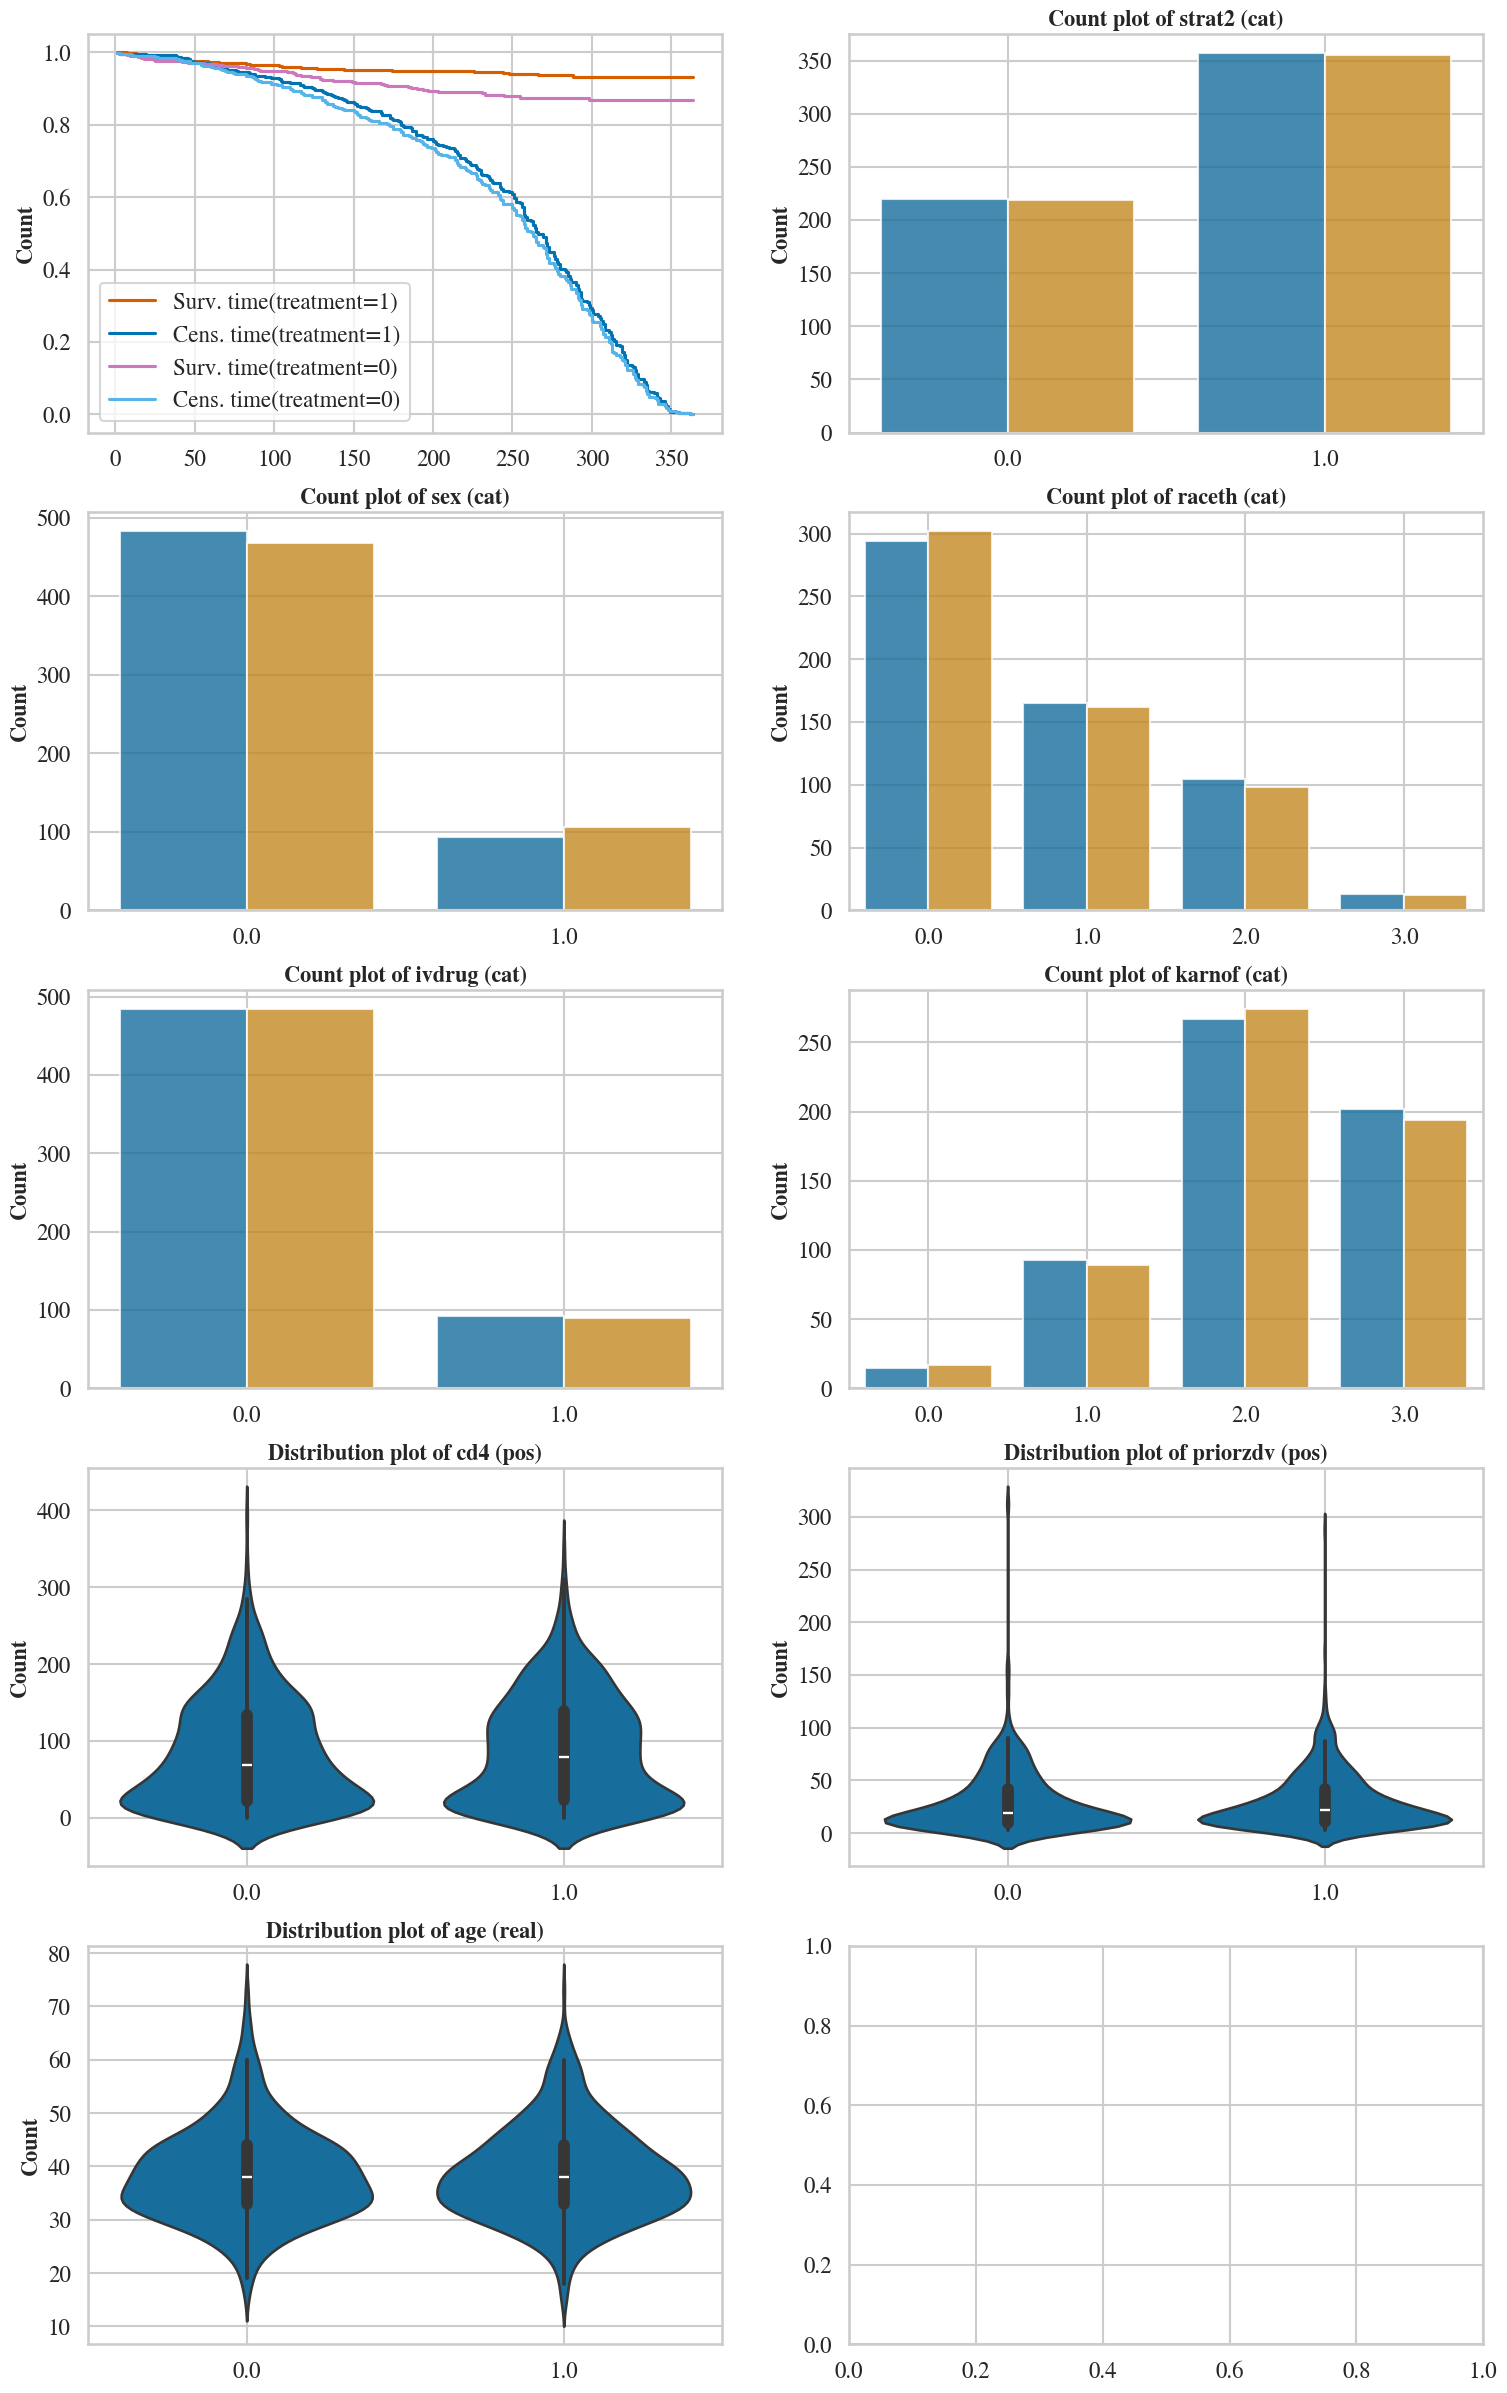

In [8]:
feat_types_dict_all = feat_types_dict.copy()#
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [9]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4', 'priorzdv', 'age']
nonnormal = ['time', 'cd4', 'priorzdv']

table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  257.0 [174.0,300.0]  251.0 [158.0,298.0]  263.0 [187.0,305.0]   0.014
censor, n (%)            0.0                               1055 (91.7)           514 (89.1)           541 (94.3)   0.002
                         1.0                                  96 (8.3)            63 (10.9)             33 (5.7)        
strat2, n (%)            0.0                                439 (38.1)           220 (38.1)           219 (38.2)   1.000
                         1.0                                712 (61.9)           357 (61.9)           355 (61.8)        
sex, n (%)               0.0    

## Training and generation from each generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [10]:
n_generated_sample = 100
# the datasets used for training is data_transformed_control

### HI-VAE

1. Data and model definition

In [11]:
model_name = "HIVAE_inputDropout" # "HIVAE_factorized"
data = data_control
miss_mask = miss_mask_control
true_miss_mask = true_miss_mask_control
dim_latent_z = 20
dim_latent_y = 15
dim_latent_s = 20
epochs = 500
lr = 1e-3
batch_size = 100
batch_size = min(batch_size, data_control.shape[0]) # Adjust batch size if larger than dataset
save_file = "{}_{}_missing_{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name, m_perc, mask, dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True) # Create directories for saving models
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
model_hivae = model_loading(input_dim=data_control.shape[1], 
                        z_dim=dim_latent_z, 
                        y_dim=dim_latent_y, 
                        s_dim=dim_latent_s, 
                        y_dim_partition=None, 
                        feat_types_file=feat_types_file_control)

2. Training

In [12]:
model_hivae, loss_train, loss_val = train_HIVAE(model_hivae, data, miss_mask, true_miss_mask, feat_types_dict, batch_size, lr, epochs)
# Saving
torch.save(model_hivae.state_dict(), network_file)
# Visualization
# visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch", xlabel = "Epoch", ylabel = "ELBO")
# visualization.plot_loss_evolution(-np.array(loss_val), title = "HI_VAE loss over epoch val", xlabel = "Epoch", ylabel = "ELBO")

Epoch: [ 0]  time: 0.0639, ELBO_train: -21.67301331, KL_z: 1.34363027, KL_s: 0.07224951, reconstruction loss: -20.25713353
Epoch: [100]  time: 2.4653, ELBO_train: -17.59379005, KL_z: 0.61200782, KL_s: 0.04001622, reconstruction loss: -16.94176601
Epoch: [200]  time: 4.8700, ELBO_train: -17.33025093, KL_z: 0.78408750, KL_s: 0.02940764, reconstruction loss: -16.51675578
Epoch: [300]  time: 7.2928, ELBO_train: -17.38994522, KL_z: 0.86447423, KL_s: 0.03139873, reconstruction loss: -16.49407227
Epoch: [400]  time: 9.7776, ELBO_train: -17.39502487, KL_z: 0.94462371, KL_s: 0.03799486, reconstruction loss: -16.41240630
Training finished.


3. Generation

In [13]:
est_data_gen_transformed_hivae = generate_from_HIVAE(model_hivae, data, miss_mask, true_miss_mask, feat_types_dict, n_generated_sample)

577


### SurvGAN     -- use a conditional GAN for tabluar data generation

1. Data and model definition

In [14]:
X = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns) # Preprocessed dataset
data = SurvivalAnalysisDataLoader(X, target_column="censor", time_to_event_column="time")
model_survgan = Plugins().get("survival_gan") 

[2025-04-23T11:49:11.702511+0200][18674][CRITICAL] module disabled: /opt/anaconda3/envs/env_synthcity/lib/python3.11/site-packages/synthcity/plugins/generic/plugin_goggle.py


2. Training

In [15]:
# Conditioning the GAN on the age and sex of the patients
# cond = X[['age', 'sex']]
cond = X[['censor']]
model_survgan.fit(data, cond=cond)

[2025-04-23T11:49:12.678398+0200][18674][CRITICAL] module disabled: /opt/anaconda3/envs/env_synthcity/lib/python3.11/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|▉         | 899/10000 [00:45<07:42, 19.68it/s]


3. Generation

In [16]:
# condition for generation ?
cond_gen = df_transformed_control[['censor']]
est_data_gen_transformed_survgan = []
for j in range(n_generated_sample):
    out = model_survgan.generate(count=577, cond=cond_gen)
    est_data_gen_transformed_survgan.append(out)

### SurvVAE -- use a VAE for tabular data generation

1. Data and model definition

In [17]:
X = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns) # Preprocessed dataset
data = SurvivalAnalysisDataLoader(X, target_column="censor", time_to_event_column="time")
model_survae = Plugins().get("survae")

[2025-04-23T11:50:07.682432+0200][18674][CRITICAL] module disabled: /opt/anaconda3/envs/env_synthcity/lib/python3.11/site-packages/synthcity/plugins/generic/plugin_goggle.py


2. Training

In [18]:
model_survae.fit(data)

[2025-04-23T11:50:07.700677+0200][18674][CRITICAL] module disabled: /opt/anaconda3/envs/env_synthcity/lib/python3.11/site-packages/synthcity/plugins/generic/plugin_goggle.py
 65%|██████▌   | 650/1000 [00:49<00:26, 13.21it/s]


3. Generation

In [19]:
est_data_gen_transformed_survae = []
for j in range(n_generated_sample):
    out = model_survae.generate(count=577)
    est_data_gen_transformed_survae.append(out)

## Statistical analysis: one generated control group vs. initial control data

In [20]:
# t-sne ? 
# import matplotlib.pyplot as plt
# syn_model.plot(plt, data)
# plt.show()


In [21]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_initial['sample'] = 1
feat_types_dict_all = feat_types_dict.copy()#
feat_types_dict_all.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})

categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','sample']
continuous = ['time', 'cd4', 'priorzdv', 'age']
nonnormal = ['time', 'cd4', 'priorzdv']

X_init = SurvivalAnalysisDataLoader(df_transformed_initial, target_column = "censor", time_to_event_column = "time")

### HI-VAE

In [22]:
list_df_transformed_generated_hivae = []
for j in range(n_generated_sample):
    df_transformed_generated_hivae_j = pd.DataFrame(est_data_gen_transformed_hivae[j].numpy(), columns=aids_control_columns)
    df_transformed_generated_hivae_j['sample'] = 0
    list_df_transformed_generated_hivae.append(df_transformed_generated_hivae_j)

comparison variable sample 10


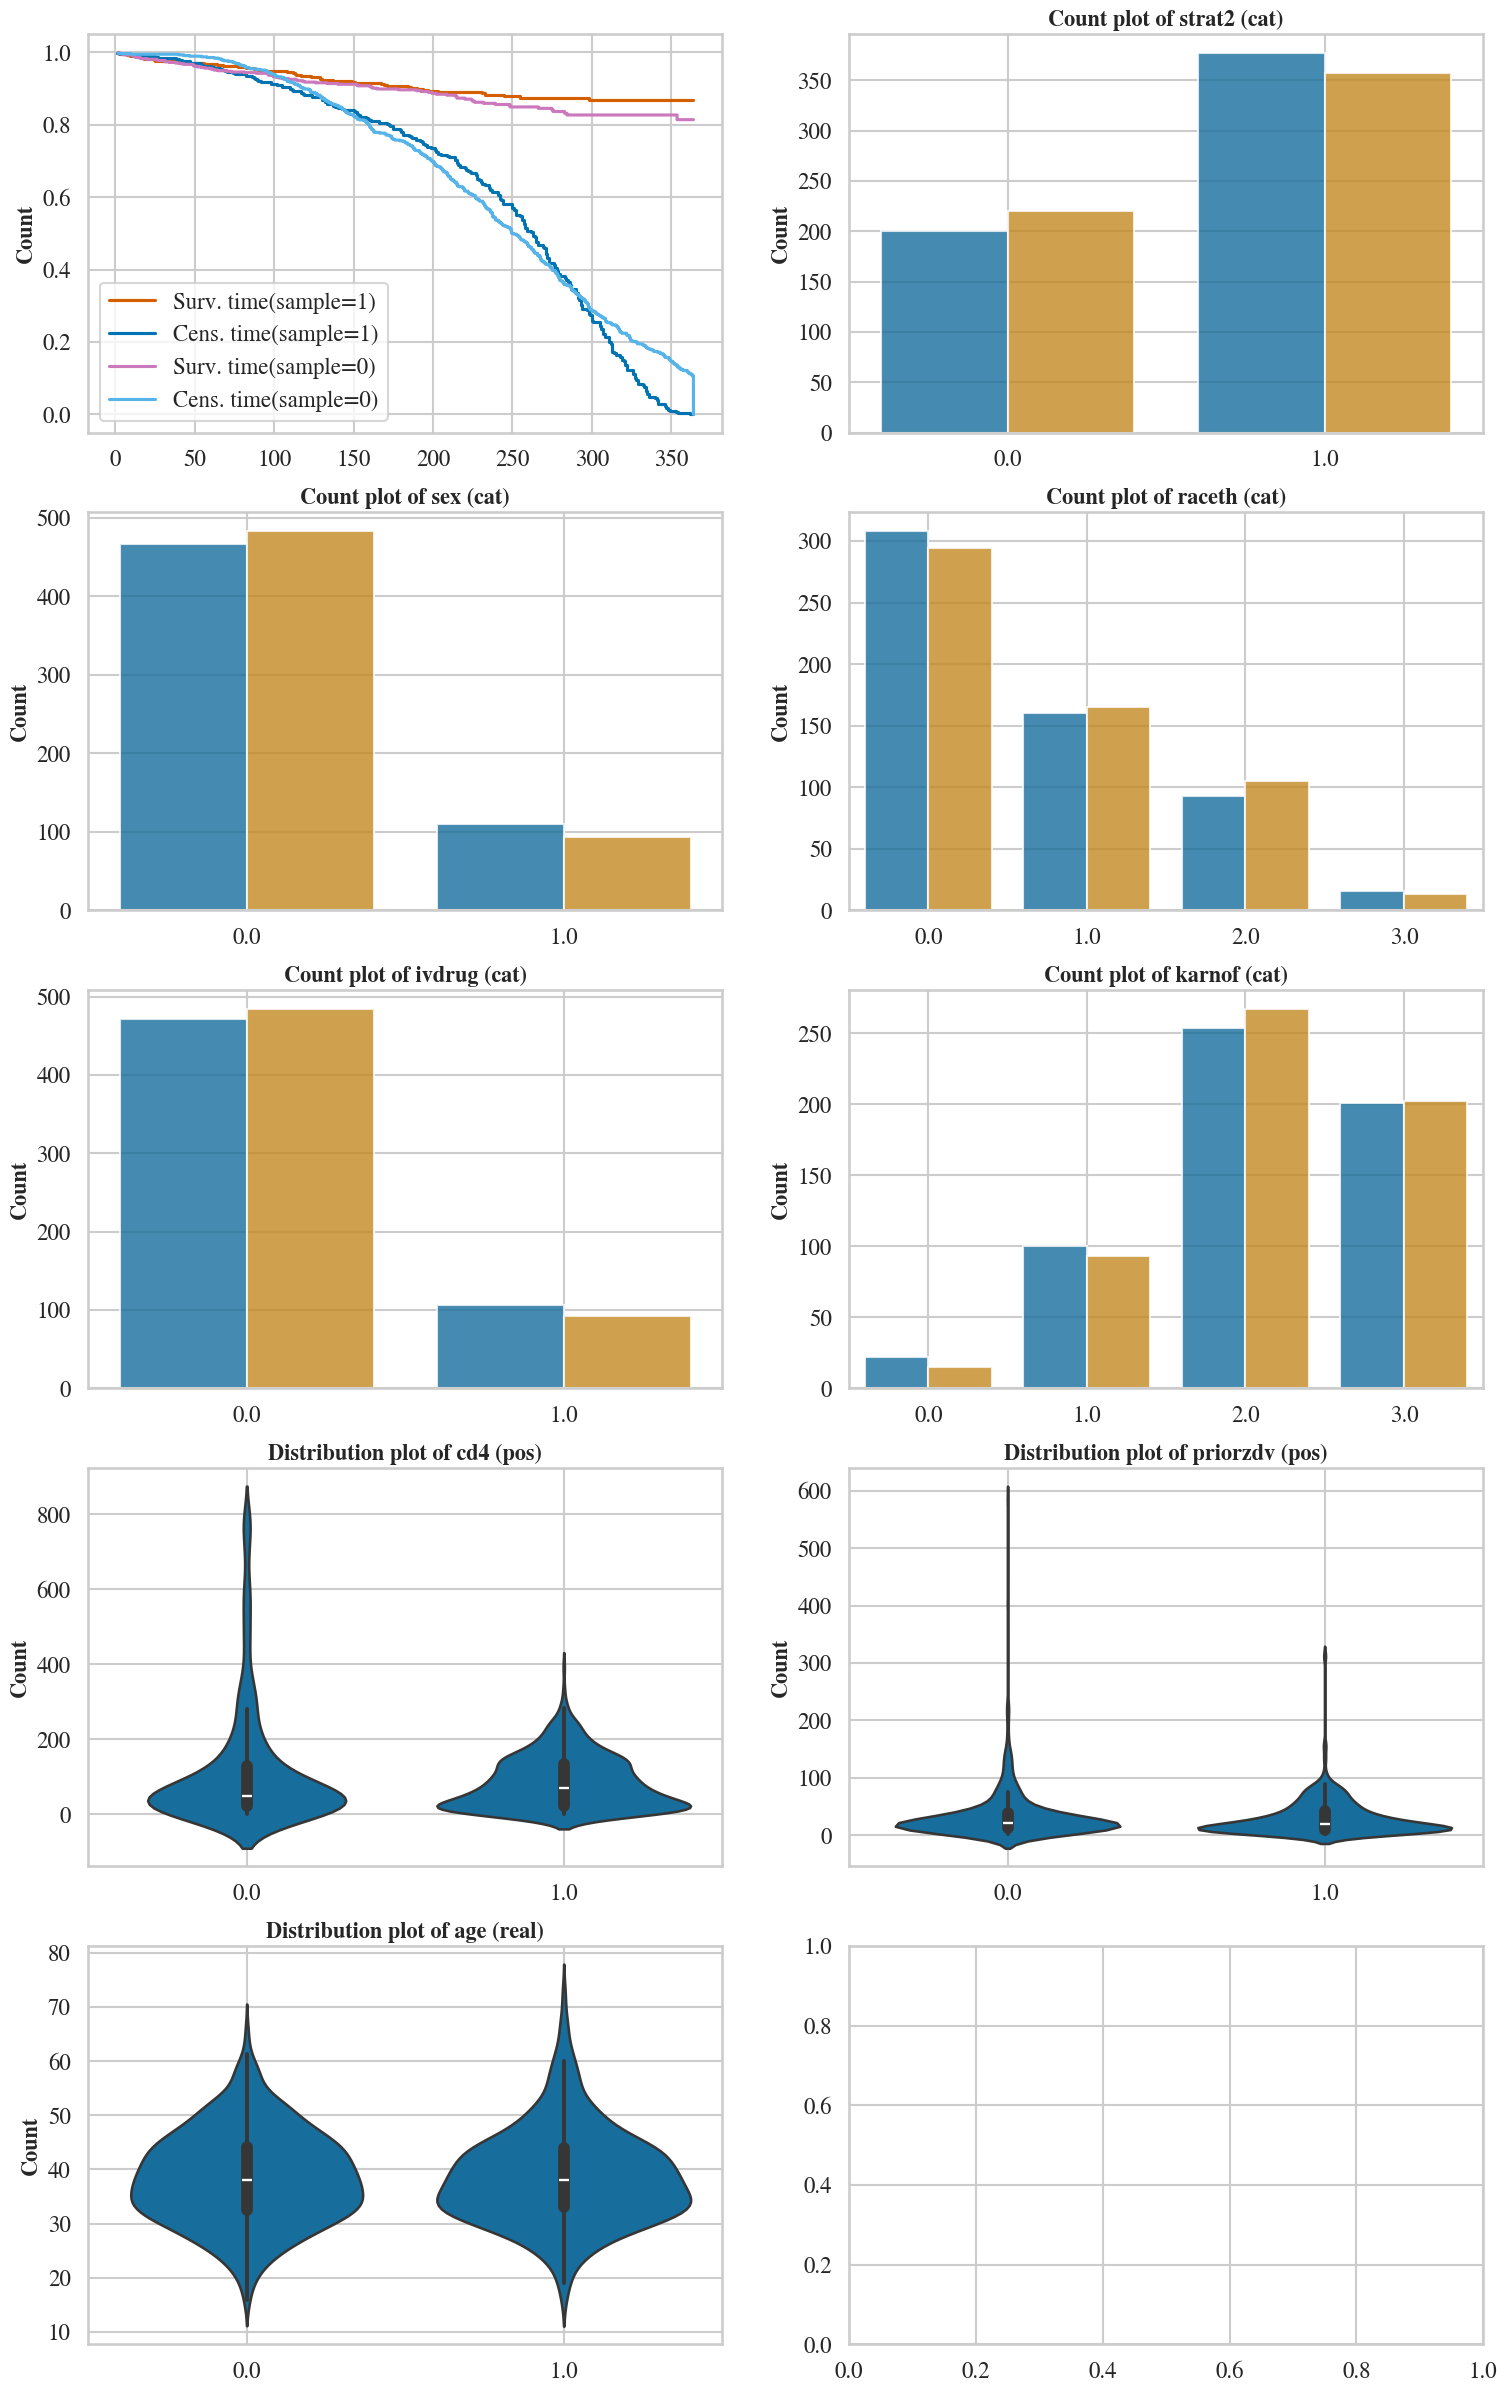

In [23]:
df_transformed_initial_generated_hivae = pd.concat([df_transformed_initial, list_df_transformed_generated_hivae[0]], ignore_index=True)
visualization.plot_compare_data(df_transformed_initial_generated_hivae.to_numpy(), feat_types_dict_all, feat_comparison_name = 'sample')

In [24]:
table1 = TableOne(df_transformed_initial_generated_hivae, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by sample                                                                       
                                       Missing              Overall                    0                    1 P-Value
n                                                              1154                  577                  577        
time, median [Q1,Q3]                         0  240.3 [152.8,298.0]  232.0 [151.0,297.8]  251.0 [158.0,298.0]   0.733
censor, n (%)            0.0                            1012 (87.7)           498 (86.3)           514 (89.1)   0.179
                         1.0                             142 (12.3)            79 (13.7)            63 (10.9)        
strat2, n (%)            0.0                             420 (36.4)           200 (34.7)           220 (38.1)   0.245
                         1.0                             734 (63.6)           377 (65.3)           357 (61.9)        
sex, n (%)               0.0                            

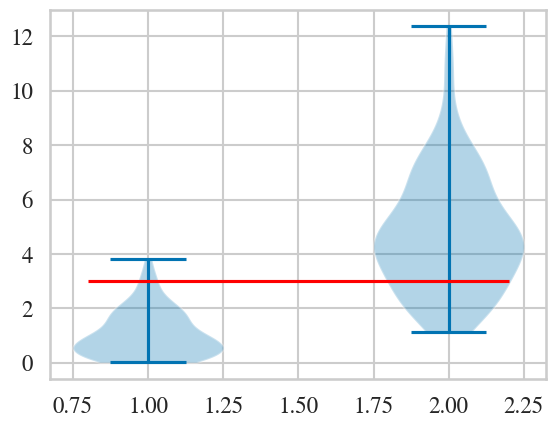

In [25]:
test_equality_survival = np.zeros((n_generated_sample,2))
for i in np.arange(n_generated_sample):
    df_transformed_initial_generated = pd.concat([df_transformed_initial, list_df_transformed_generated_hivae[i]], ignore_index=True)
    Y_T = Surv.from_arrays(df_transformed_initial_generated.to_numpy()[:,1]==1, df_transformed_initial_generated.to_numpy()[:,0])
    Y_C = Surv.from_arrays(df_transformed_initial_generated.to_numpy()[:,1]==0, df_transformed_initial_generated.to_numpy()[:,0])
    test_equality_survival[i,0] = compare_survival(Y_T, df_transformed_initial_generated.to_numpy()[:,-1])[1]
    test_equality_survival[i,1] = compare_survival(Y_C, df_transformed_initial_generated.to_numpy()[:,-1])[1]

plt.violinplot(-np.log(test_equality_survival))
plt.hlines(-np.log(0.05),0.8,2.2,color='red')

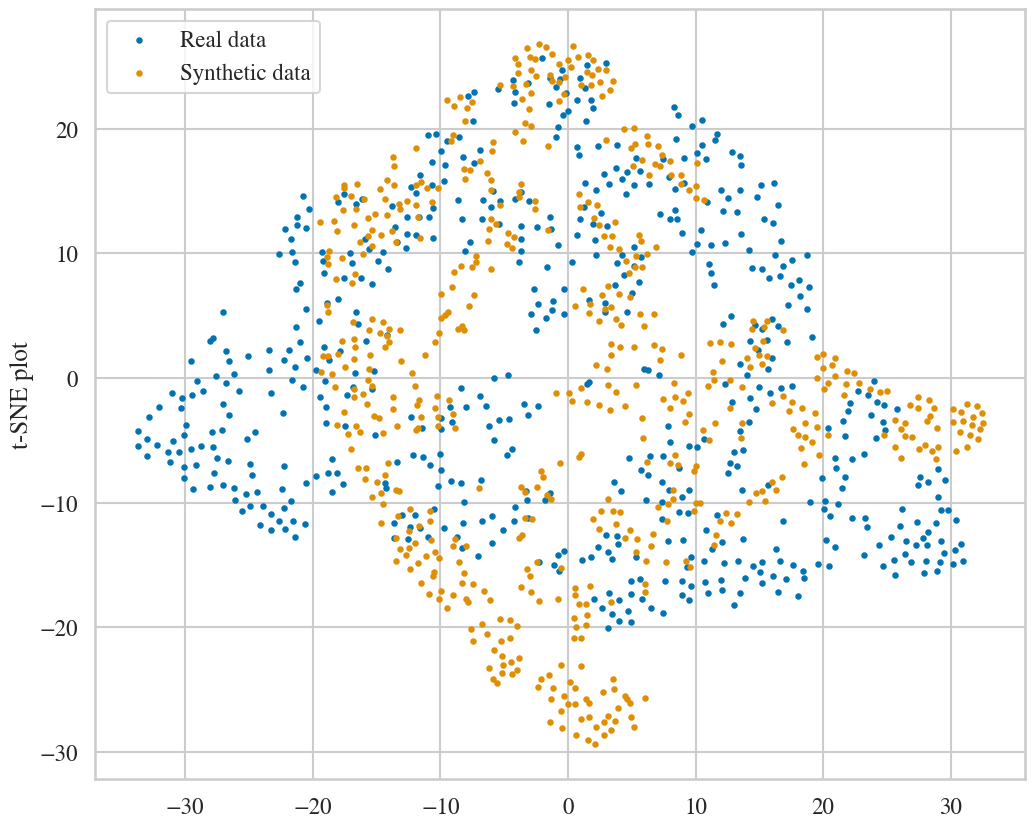

In [26]:
X_syn_hivae = SurvivalAnalysisDataLoader(list_df_transformed_generated_hivae[0], target_column = "censor", time_to_event_column = "time")
plot_tsne(plt, X_init, X_syn_hivae)

### SurvGAN

In [27]:
list_df_transformed_generated_survgan = []
for j in range(n_generated_sample):
    df_transformed_generated_survgan_j = pd.DataFrame(est_data_gen_transformed_survgan[j].numpy(), columns=aids_control_columns)
    df_transformed_generated_survgan_j['sample'] = 0
    list_df_transformed_generated_survgan.append(df_transformed_generated_survgan_j)

comparison variable sample 10


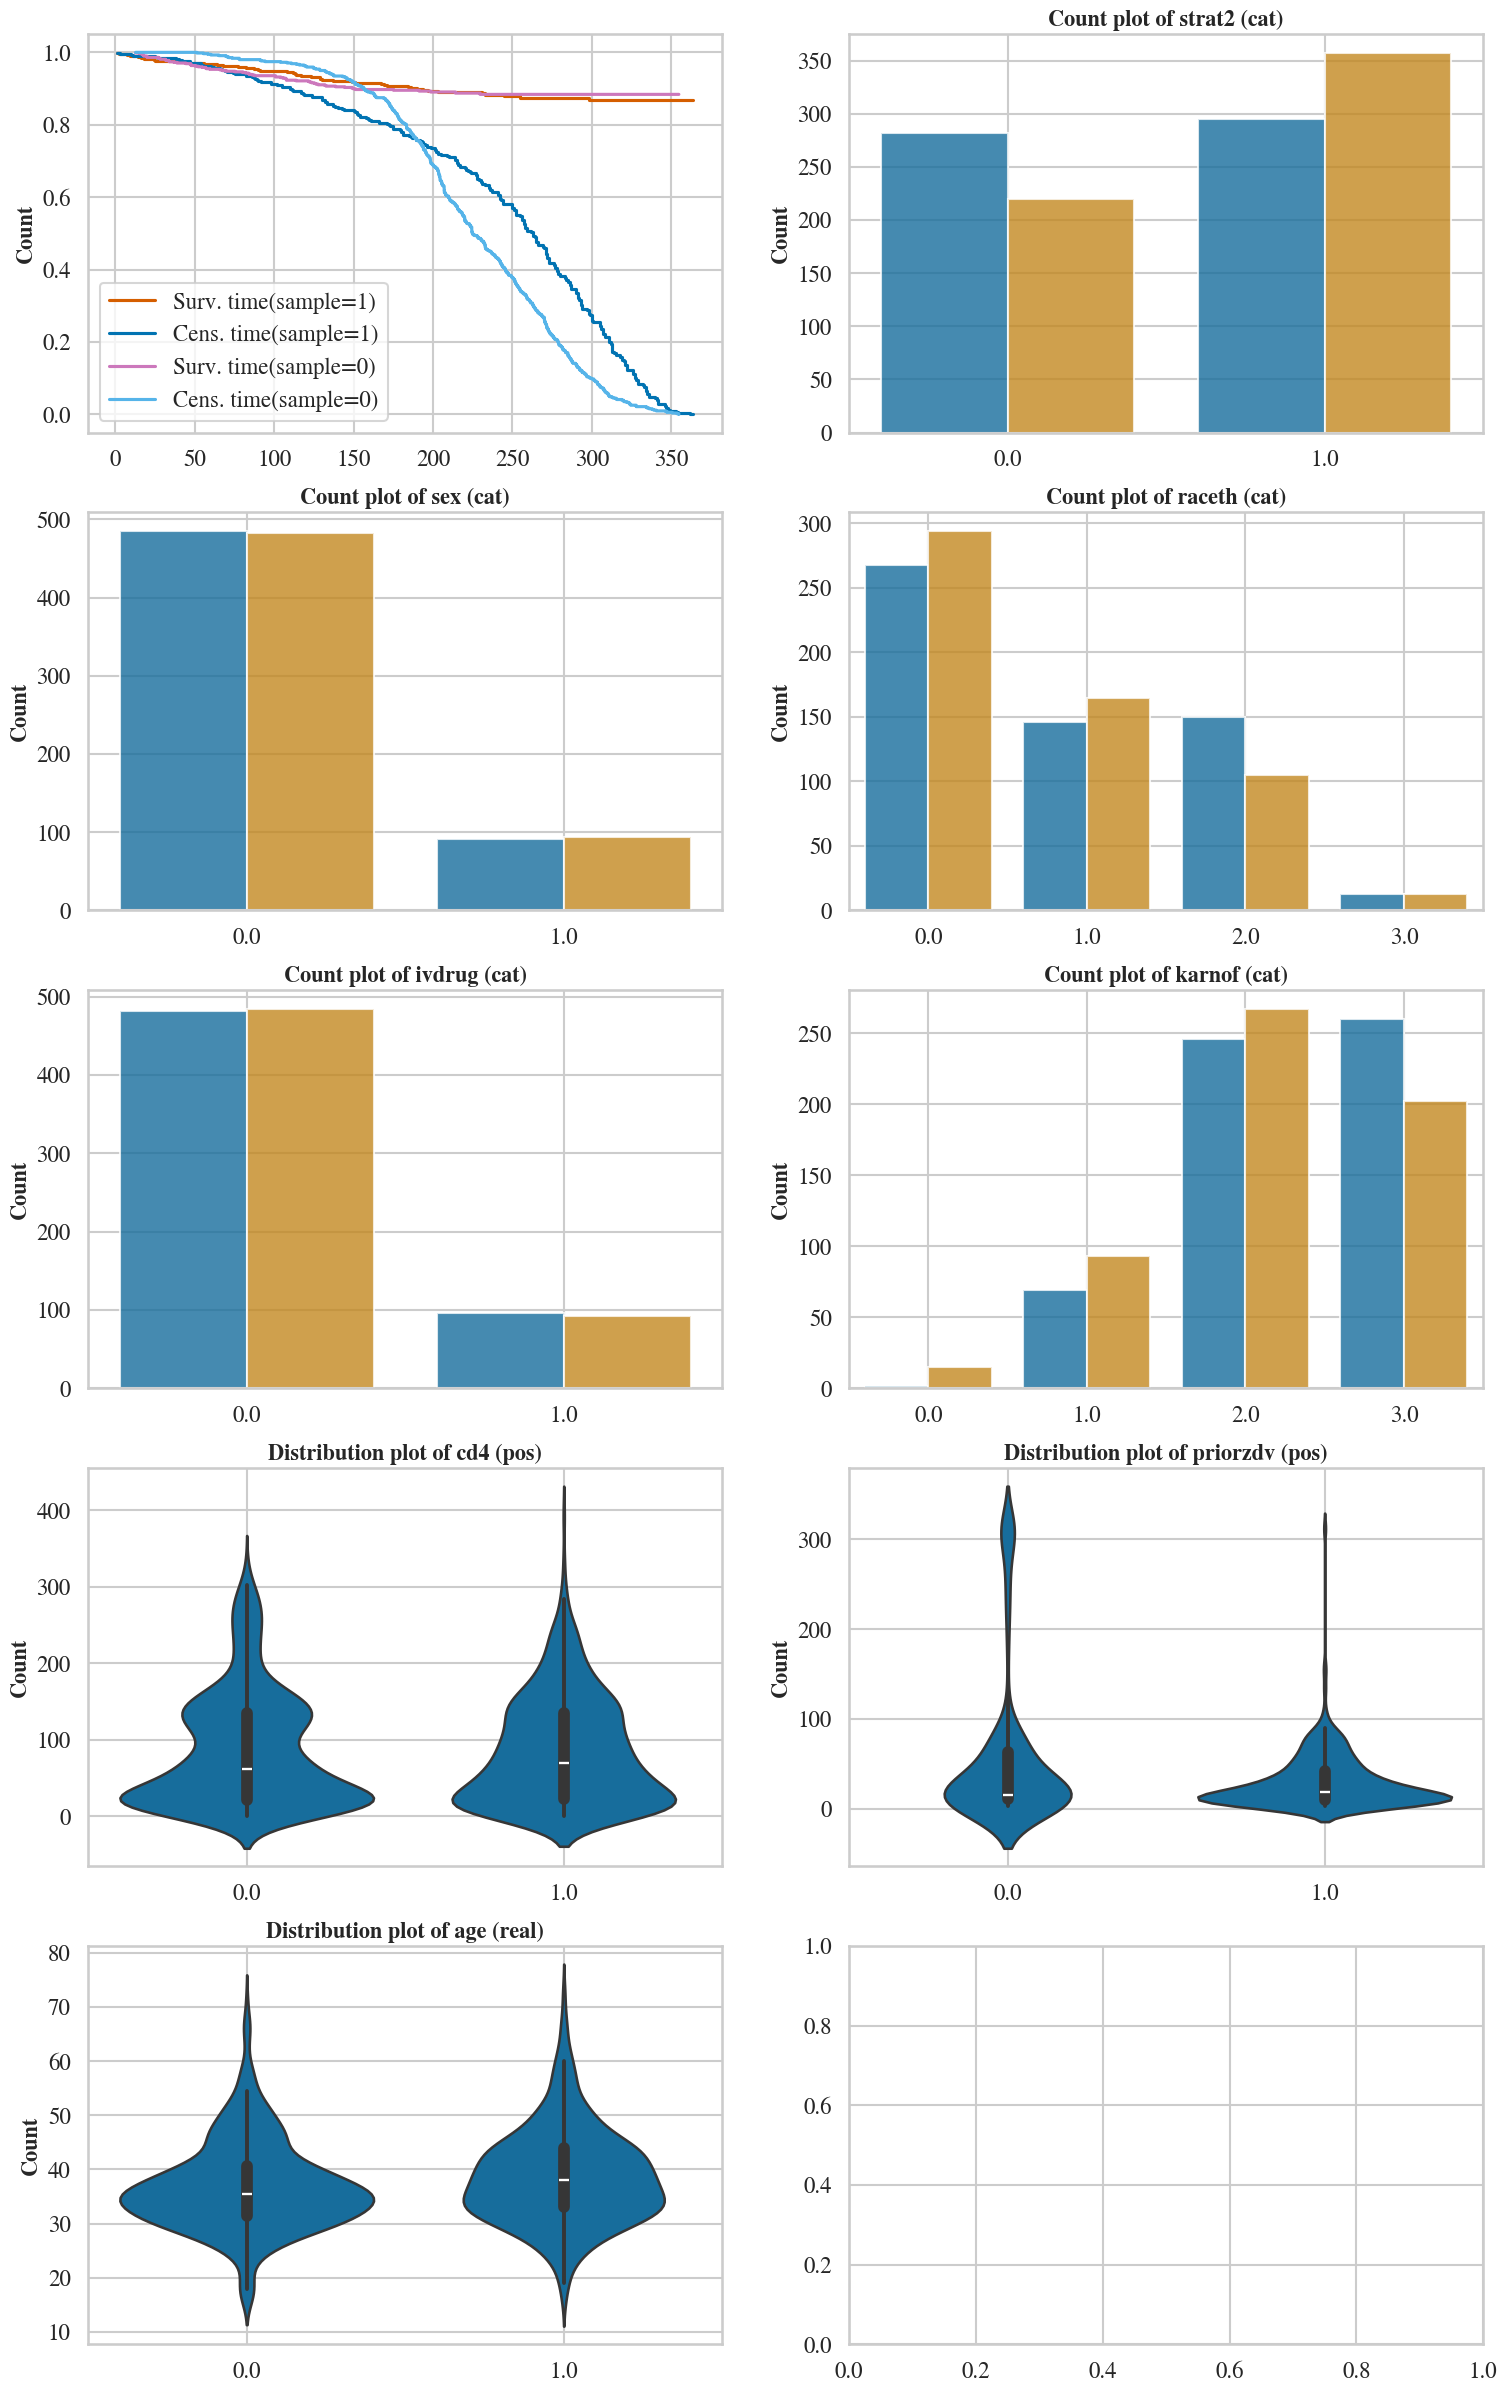

In [28]:
df_transformed_initial_generated_survgan = pd.concat([df_transformed_initial, list_df_transformed_generated_survgan[0]], ignore_index=True)
visualization.plot_compare_data(df_transformed_initial_generated_survgan.to_numpy(), feat_types_dict_all, feat_comparison_name = 'sample')

In [29]:
table1 = TableOne(df_transformed_initial_generated_survgan, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by sample                                                                       
                                       Missing              Overall                    0                    1 P-Value
n                                                              1154                  577                  577        
time, median [Q1,Q3]                         0  230.0 [172.0,280.8]  216.4 [175.7,266.0]  251.0 [158.0,298.0]  <0.001
censor, n (%)            0.0                            1028 (89.1)           514 (89.1)           514 (89.1)   1.000
                         1.0                             126 (10.9)            63 (10.9)            63 (10.9)        
strat2, n (%)            0.0                             502 (43.5)           282 (48.9)           220 (38.1)  <0.001
                         1.0                             652 (56.5)           295 (51.1)           357 (61.9)        
sex, n (%)               0.0                            

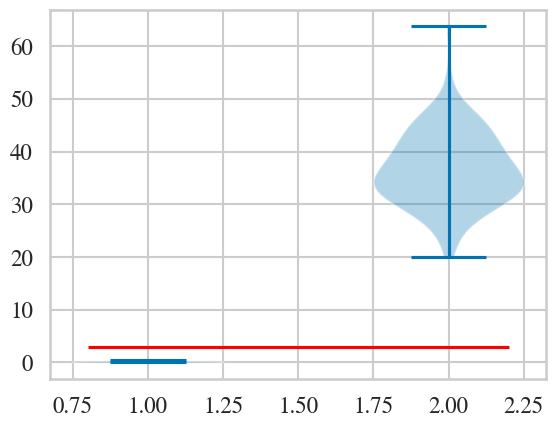

In [30]:
test_equality_survival = np.zeros((n_generated_sample,2))
for i in np.arange(n_generated_sample):
    df_transformed_initial_generated = pd.concat([df_transformed_initial, list_df_transformed_generated_survgan[i]], ignore_index=True)
    Y_T = Surv.from_arrays(df_transformed_initial_generated.to_numpy()[:,1]==1, df_transformed_initial_generated.to_numpy()[:,0])
    Y_C = Surv.from_arrays(df_transformed_initial_generated.to_numpy()[:,1]==0, df_transformed_initial_generated.to_numpy()[:,0])
    test_equality_survival[i,0] = compare_survival(Y_T, df_transformed_initial_generated.to_numpy()[:,-1])[1]
    test_equality_survival[i,1] = compare_survival(Y_C, df_transformed_initial_generated.to_numpy()[:,-1])[1]

plt.violinplot(-np.log(test_equality_survival))
plt.hlines(-np.log(0.05),0.8,2.2,color='red')

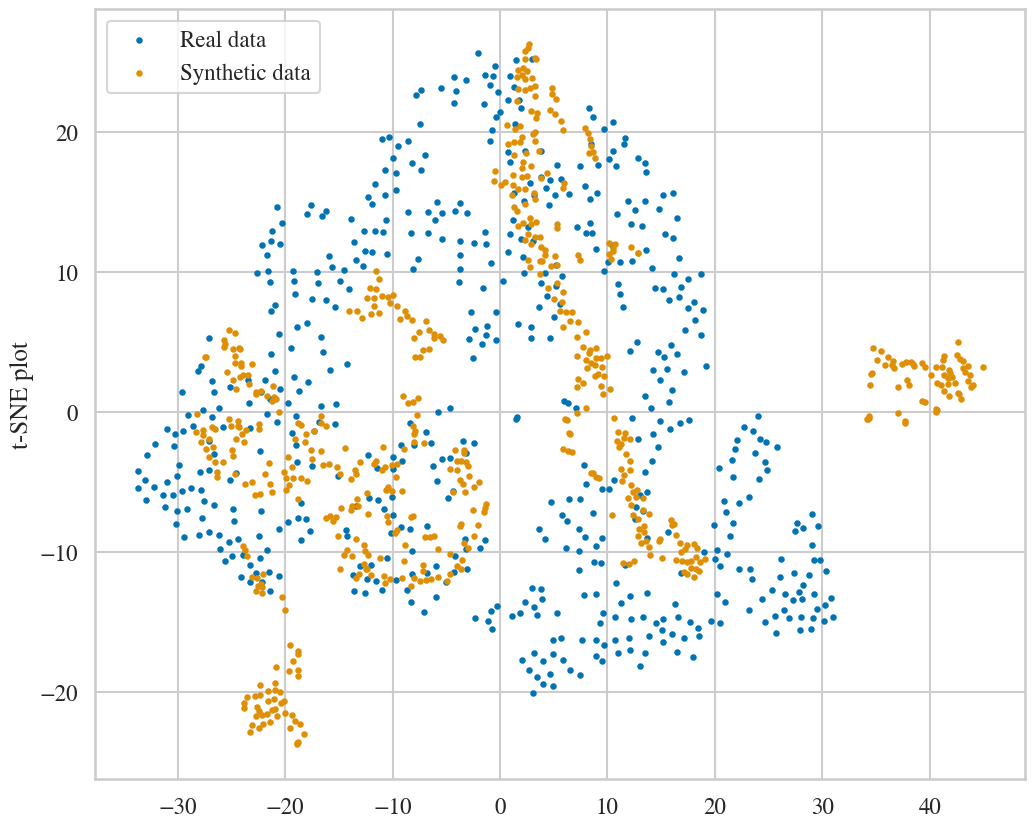

In [31]:
X_syn_survgan = SurvivalAnalysisDataLoader(list_df_transformed_generated_survgan[0], target_column = "censor", time_to_event_column = "time")
plot_tsne(plt, X_init, X_syn_survgan)

### SurvVAE

In [32]:
list_df_transformed_generated_survae = []
for j in range(n_generated_sample):
    df_transformed_generated_survae_j = pd.DataFrame(est_data_gen_transformed_survae[j].numpy(), columns=aids_control_columns)
    df_transformed_generated_survae_j['sample'] = 0
    list_df_transformed_generated_survae.append(df_transformed_generated_survae_j)

comparison variable sample 10


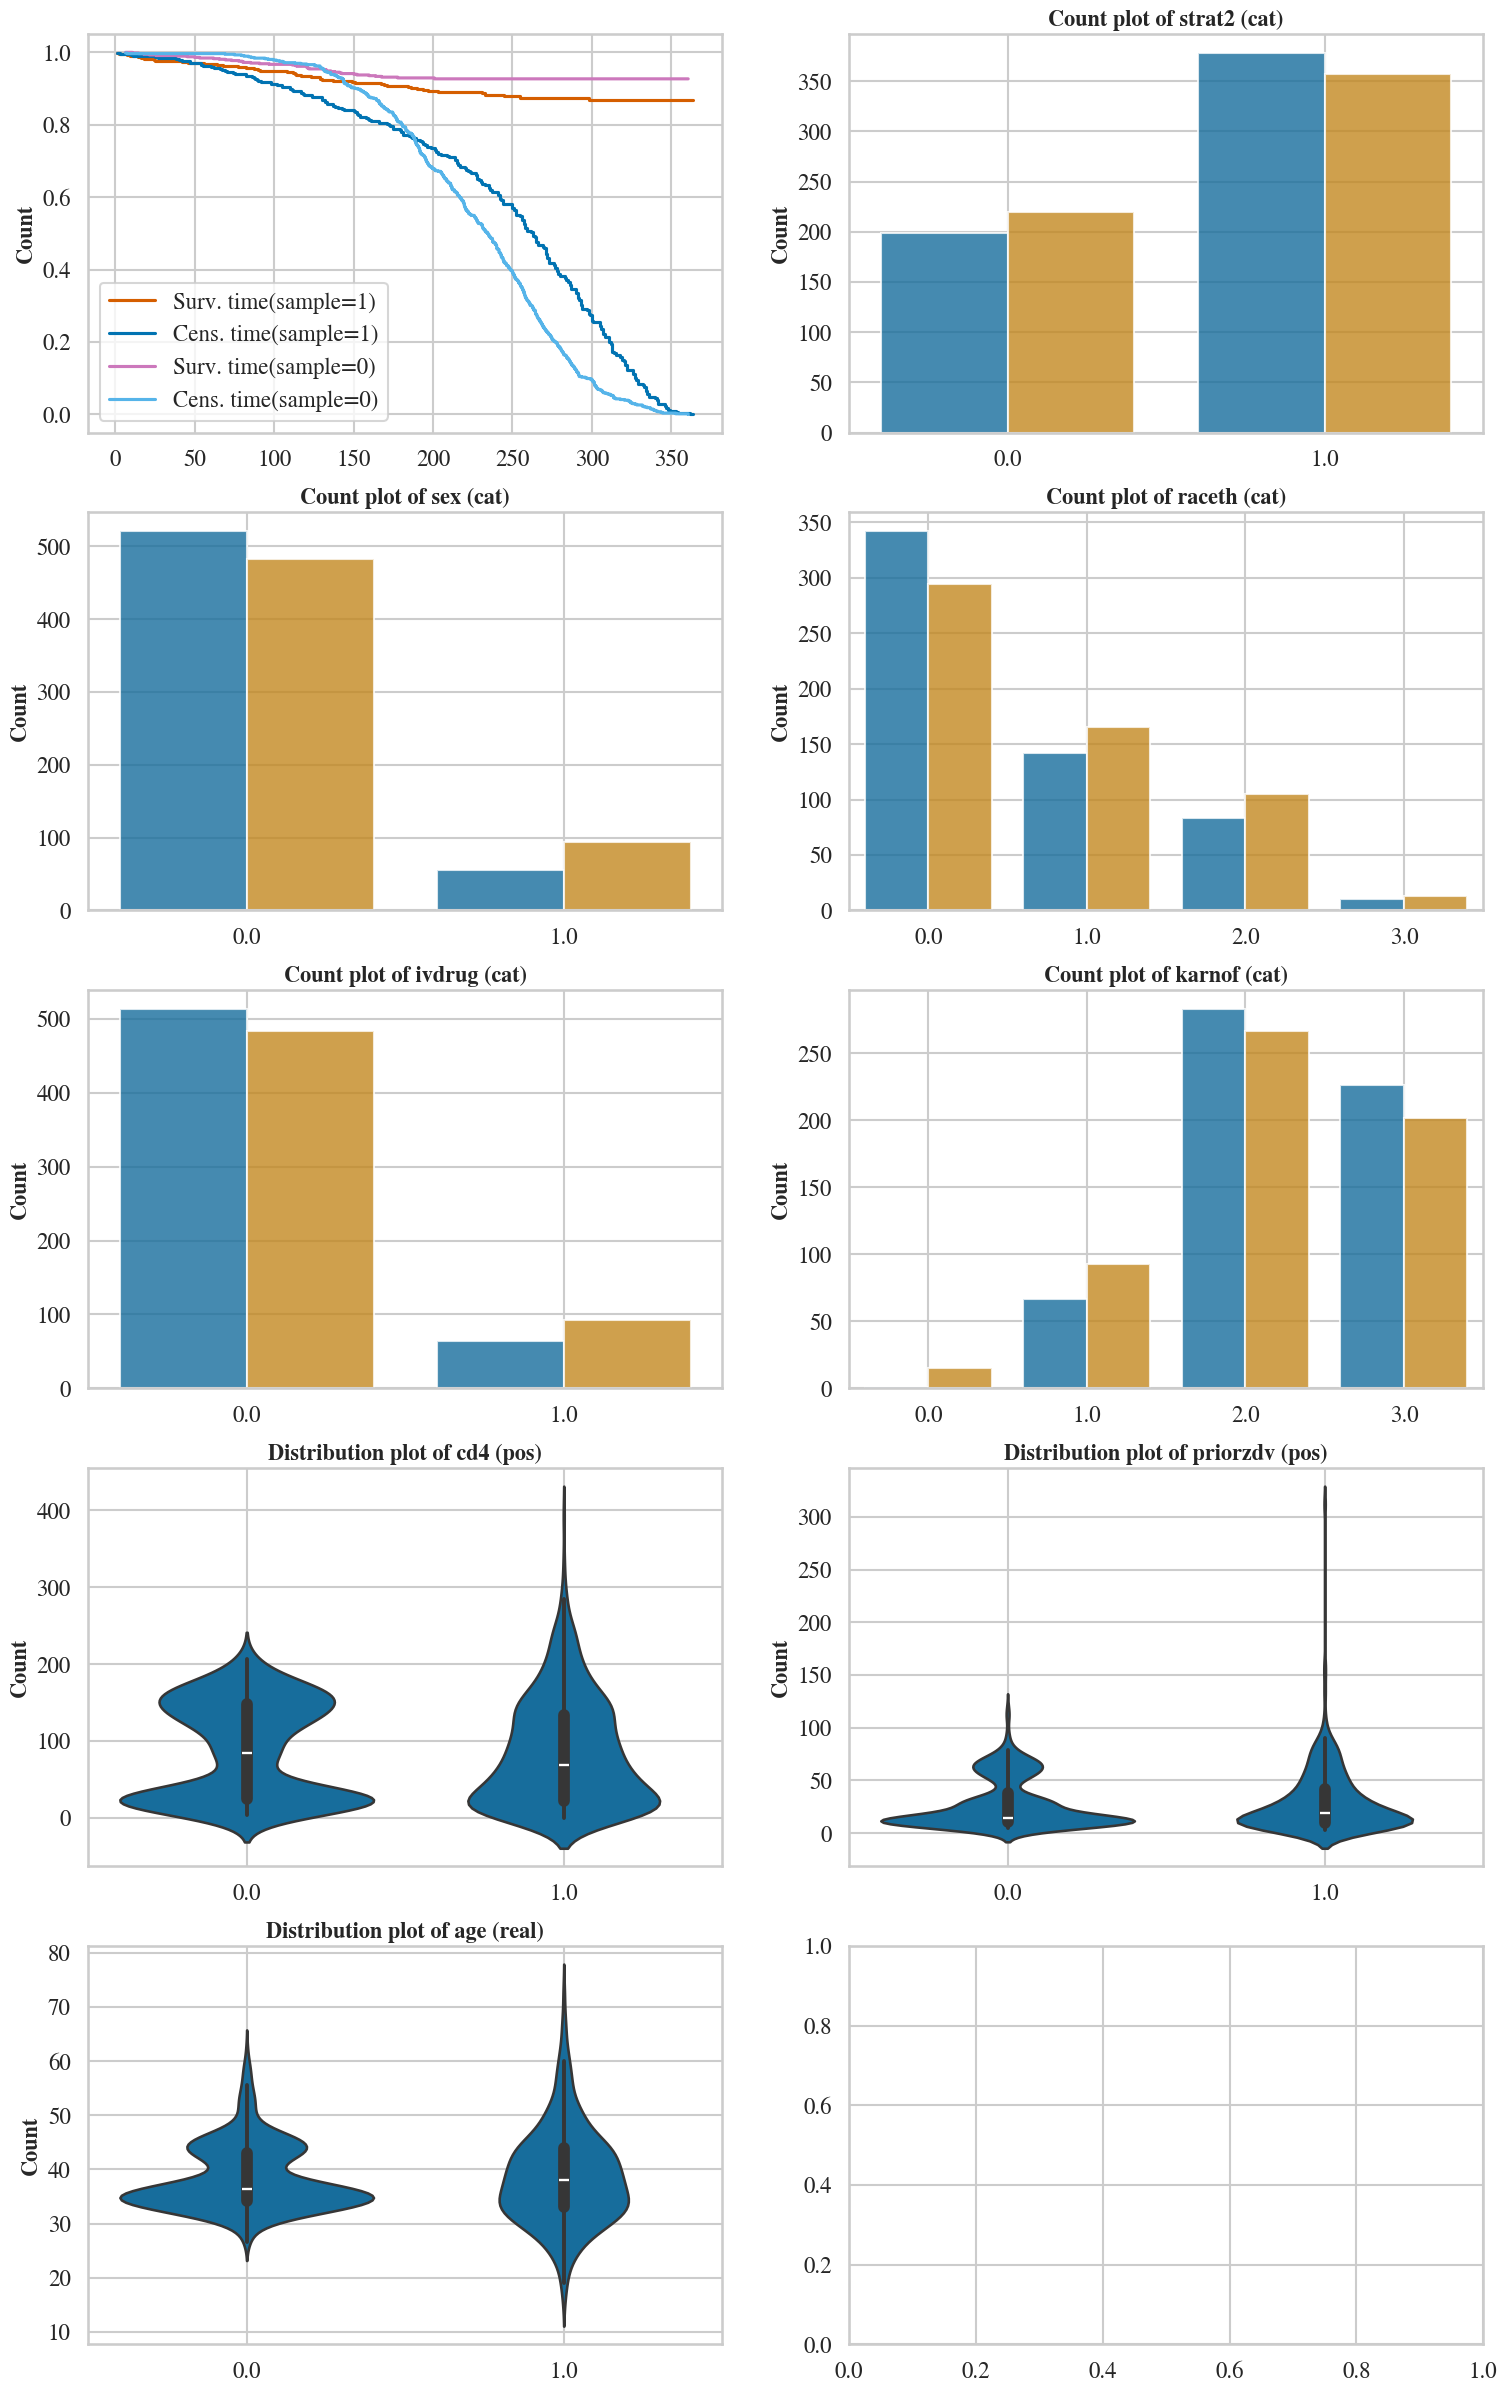

In [33]:
df_transformed_initial_generated_survae = pd.concat([df_transformed_initial, list_df_transformed_generated_survae[0]], ignore_index=True)
visualization.plot_compare_data(df_transformed_initial_generated_survae.to_numpy(), feat_types_dict_all, feat_comparison_name = 'sample')

In [34]:
table1 = TableOne(df_transformed_initial_generated_survae, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by sample                                                                       
                                       Missing              Overall                    0                    1 P-Value
n                                                              1154                  577                  577        
time, median [Q1,Q3]                         0  236.0 [174.5,280.7]  227.4 [179.9,265.6]  251.0 [158.0,298.0]   0.001
censor, n (%)            0.0                            1051 (91.1)           537 (93.1)           514 (89.1)   0.023
                         1.0                              103 (8.9)             40 (6.9)            63 (10.9)        
strat2, n (%)            0.0                             419 (36.3)           199 (34.5)           220 (38.1)   0.221
                         1.0                             735 (63.7)           378 (65.5)           357 (61.9)        
sex, n (%)               0.0                            

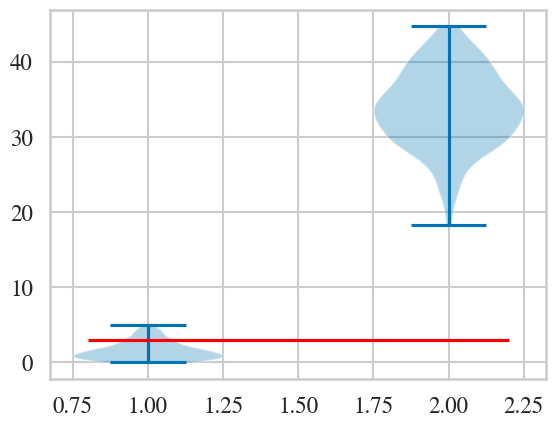

In [35]:
test_equality_survival = np.zeros((n_generated_sample,2))
for i in np.arange(n_generated_sample):
    df_transformed_initial_generated = pd.concat([df_transformed_initial, list_df_transformed_generated_survae[i]], ignore_index=True)
    Y_T = Surv.from_arrays(df_transformed_initial_generated.to_numpy()[:,1]==1, df_transformed_initial_generated.to_numpy()[:,0])
    Y_C = Surv.from_arrays(df_transformed_initial_generated.to_numpy()[:,1]==0, df_transformed_initial_generated.to_numpy()[:,0])
    test_equality_survival[i,0] = compare_survival(Y_T, df_transformed_initial_generated.to_numpy()[:,-1])[1]
    test_equality_survival[i,1] = compare_survival(Y_C, df_transformed_initial_generated.to_numpy()[:,-1])[1]

plt.violinplot(-np.log(test_equality_survival))
plt.hlines(-np.log(0.05), 0.8, 2.2, color='red')

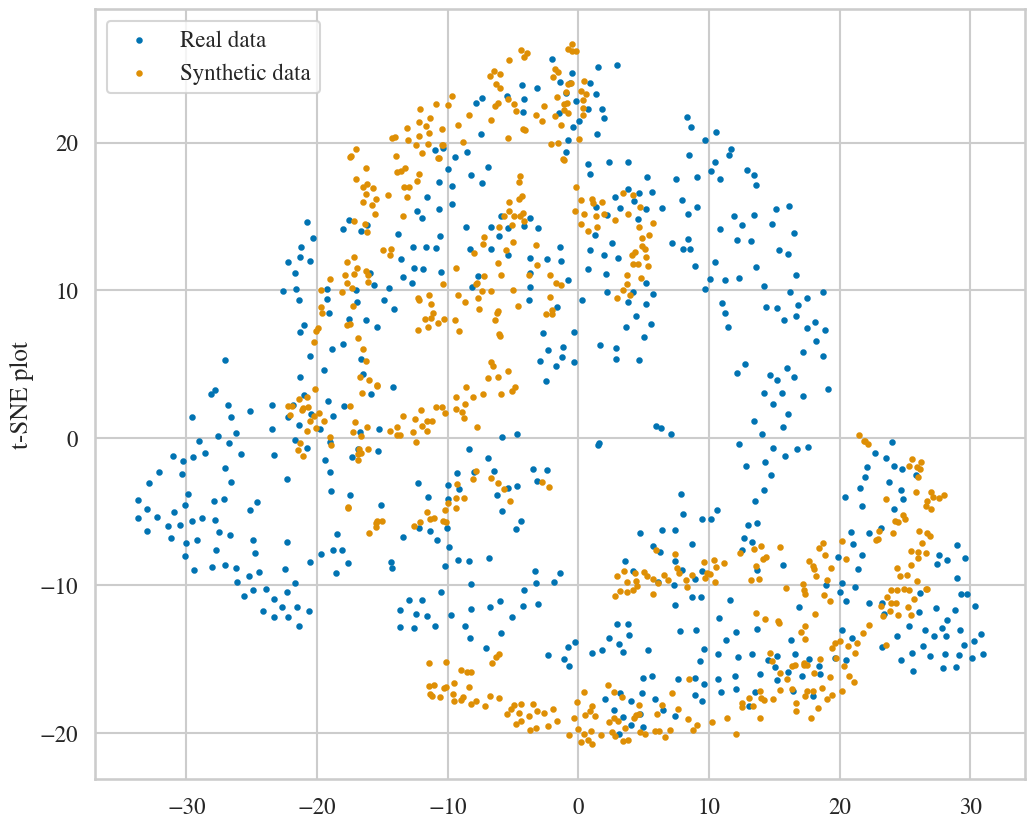

In [36]:
X_syn_survae = SurvivalAnalysisDataLoader(list_df_transformed_generated_survae[0], target_column = "censor", time_to_event_column = "time")
plot_tsne(plt, X_init, X_syn_survae)

## Statistical analysis: one generated control group vs. initial treated data

In [37]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4', 'priorzdv', 'age']
nonnormal = ['time', 'cd4', 'priorzdv']

time_initial_C, survival_prob_initial_C, conf_int_initial_C = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,0], conf_type="log-log")

time_initial_T, survival_prob_initial_T, conf_int_initial_T = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,0], conf_type="log-log")

### HI-VAE

In [38]:
df_transformed_generated_hivae = pd.DataFrame(est_data_gen_transformed_hivae[0].numpy(), columns=aids_control_columns)
df_transformed_generated_hivae['treatment'] = 0
df_transformed_T_Cgen_hivae = pd.concat([df_transformed_treated, df_transformed_generated_hivae], ignore_index=True)
table1 = TableOne(df_transformed_T_Cgen_hivae, categorical=categorical, continuous=continuous, groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  250.0 [162.9,301.0]  232.0 [151.0,297.8]  263.0 [187.0,305.0]   0.008
censor, n (%)            0.0                               1039 (90.3)           498 (86.3)           541 (94.3)  <0.001
                         1.0                                 112 (9.7)            79 (13.7)             33 (5.7)        
strat2, n (%)            0.0                                419 (36.4)           200 (34.7)           219 (38.2)   0.242
                         1.0                                732 (63.6)           377 (65.3)           355 (61.8)        
sex, n (%)               0.0    

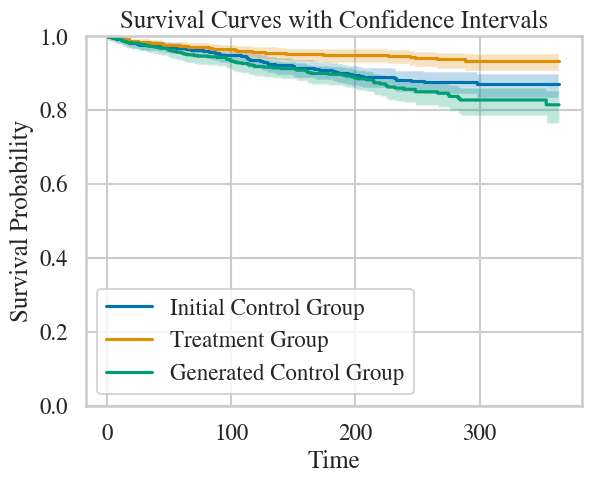

In [39]:
time_T_Cgen_C_hivae, survival_prob_T_Cgen_C_hivae, conf_int_T_Cgen_C_hivae = kaplan_meier_estimator(
    df_transformed_T_Cgen_hivae[df_transformed_T_Cgen_hivae['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen_hivae[df_transformed_T_Cgen_hivae['treatment']==0].to_numpy()[:,0], conf_type="log-log")

plt.step(time_initial_C, survival_prob_initial_C, where="post", label="Initial Control Group")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post", label="Treatment Group")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")

plt.step(time_T_Cgen_C_hivae, survival_prob_T_Cgen_C_hivae, where="post", label="Generated Control Group")
plt.fill_between(time_T_Cgen_C_hivae, conf_int_T_Cgen_C_hivae[0], conf_int_T_Cgen_C_hivae[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")
plt.show()

### SurvGAN

In [40]:
df_transformed_generated_survgan = pd.DataFrame(est_data_gen_transformed_survgan[0].numpy(), columns=aids_control_columns)
df_transformed_generated_survgan['treatment'] = 0
df_transformed_T_Cgen_survgan = pd.concat([df_transformed_treated, df_transformed_generated_survgan], ignore_index=True)
table1 = TableOne(df_transformed_T_Cgen_survgan, categorical=categorical, continuous=continuous, groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  237.3 [178.8,285.1]  216.4 [175.7,266.0]  263.0 [187.0,305.0]  <0.001
censor, n (%)            0.0                               1055 (91.7)           514 (89.1)           541 (94.3)   0.002
                         1.0                                  96 (8.3)            63 (10.9)             33 (5.7)        
strat2, n (%)            0.0                                501 (43.5)           282 (48.9)           219 (38.2)  <0.001
                         1.0                                650 (56.5)           295 (51.1)           355 (61.8)        
sex, n (%)               0.0    

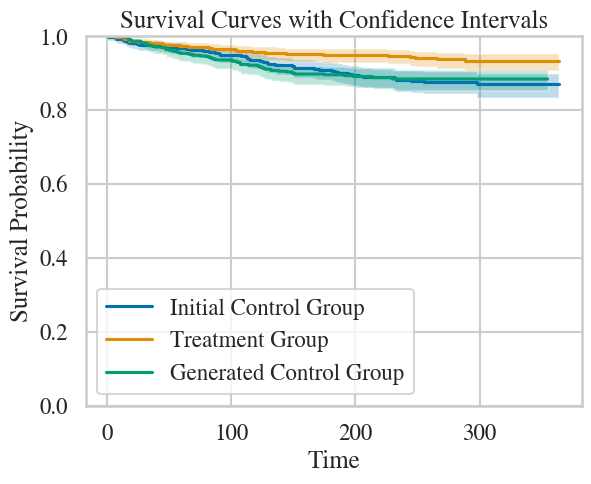

In [41]:
time_T_Cgen_C_survgan, survival_prob_T_Cgen_C_survgan, conf_int_T_Cgen_C_survgan = kaplan_meier_estimator(
    df_transformed_T_Cgen_survgan[df_transformed_T_Cgen_survgan['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen_survgan[df_transformed_T_Cgen_survgan['treatment']==0].to_numpy()[:,0], conf_type="log-log")

plt.step(time_initial_C, survival_prob_initial_C, where="post", label="Initial Control Group")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post", label="Treatment Group")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")

plt.step(time_T_Cgen_C_survgan, survival_prob_T_Cgen_C_survgan, where="post", label="Generated Control Group")
plt.fill_between(time_T_Cgen_C_survgan, conf_int_T_Cgen_C_survgan[0], conf_int_T_Cgen_C_survgan[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")
plt.show()

### SurvVAE

In [42]:
df_transformed_generated_survae = pd.DataFrame(est_data_gen_transformed_survae[0].numpy(), columns=aids_control_columns)
df_transformed_generated_survae['treatment'] = 0
df_transformed_T_Cgen_survae = pd.concat([df_transformed_treated, df_transformed_generated_survae], ignore_index=True)
table1 = TableOne(df_transformed_T_Cgen_survae, categorical=categorical, continuous=continuous, groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  243.0 [180.9,285.0]  227.4 [179.9,265.6]  263.0 [187.0,305.0]  <0.001
censor, n (%)            0.0                               1078 (93.7)           537 (93.1)           541 (94.3)   0.482
                         1.0                                  73 (6.3)             40 (6.9)             33 (5.7)        
strat2, n (%)            0.0                                418 (36.3)           199 (34.5)           219 (38.2)   0.218
                         1.0                                733 (63.7)           378 (65.5)           355 (61.8)        
sex, n (%)               0.0    

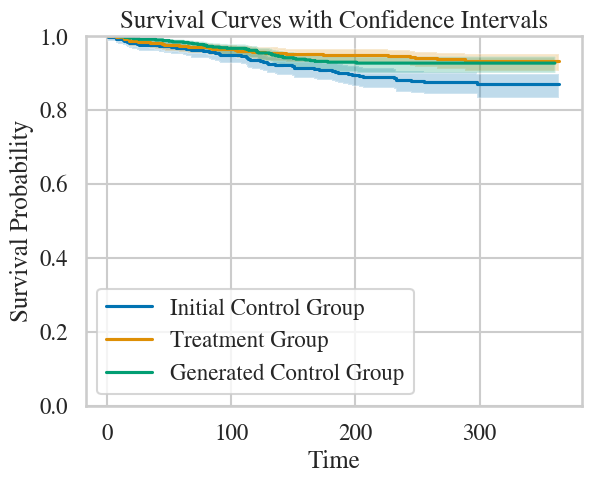

In [43]:
time_T_Cgen_C_survae, survival_prob_T_Cgen_C_survae, conf_int_T_Cgen_C_survae = kaplan_meier_estimator(
    df_transformed_T_Cgen_survae[df_transformed_T_Cgen_survae['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen_survae[df_transformed_T_Cgen_survae['treatment']==0].to_numpy()[:,0], conf_type="log-log")

plt.step(time_initial_C, survival_prob_initial_C, where="post", label="Initial Control Group")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post", label="Treatment Group")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")

plt.step(time_T_Cgen_C_survae, survival_prob_T_Cgen_C_survae, where="post", label="Generated Control Group")
plt.fill_between(time_T_Cgen_C_survae, conf_int_T_Cgen_C_survae[0], conf_int_T_Cgen_C_survae[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")
plt.show()

## Metrics form synthcity: initial control data vs. all generated synthetic control groups

All the metrics available in synthcity are detailled here: [https://github.com/vanderschaarlab/synthcity/tree/main#zap-evaluation-metrics](https://github.com/vanderschaarlab/synthcity/tree/main#zap-evaluation-metrics) 

In [44]:
X_init = SurvivalAnalysisDataLoader(df_transformed_initial, target_column = "censor", time_to_event_column = "time")

# Set display options
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Prevent line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content of each column


### HI-VAE

In [45]:
scores_hivae = ScoreEvaluator()
for j in range(n_generated_sample):
    enable_reproducible_results(j)
    clear_cache()

    X_syn = SurvivalAnalysisDataLoader(list_df_transformed_generated_hivae[j], 
                                       target_column = "censor", 
                                       time_to_event_column = "time")

    evaluation = Metrics().evaluate(X_gt=X_init, # can be dataloaders or dataframes
                                    X_syn=X_syn, 
                                    reduction='mean', # default mean
                                    n_histogram_bins=10, # default 10
                                    metrics=None, # all metrics
                                    task_type='survival_analysis', 
                                    use_cache=True)

    mean_score = evaluation["mean"].to_dict()
    errors = evaluation["errors"].to_dict()
    duration = evaluation["durations"].to_dict()
    direction = evaluation["direction"].to_dict()

    for key in mean_score:
        scores_hivae.add(key,
                         mean_score[key],
                         errors[key],
                         duration[key],
                         direction[key])

out_hivae = scores_hivae.to_dataframe()
out_hivae

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.data_mismatch.score,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,100,0,0.00,minimize
sanity.common_rows_proportion.score,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,100,0,0.00,minimize
sanity.nearest_syn_neighbor_distance.mean,0.078046,0.209916,0.111442,2.650105e-02,0.104711,3.051875e-02,100,0,0.00,minimize
sanity.close_values_probability.score,0.570191,0.968804,0.891179,7.558762e-02,0.918544,7.972270e-02,100,0,0.00,maximize
sanity.distant_values_probability.score,0.001733,0.010399,0.002652,1.307430e-03,0.001733,1.733102e-03,100,0,0.00,minimize
stats.jensenshannon_dist.marginal,0.026305,0.029250,0.027637,6.106762e-04,0.027671,8.528241e-04,100,0,0.02,minimize
stats.chi_squared_test.marginal,0.797705,0.992827,0.848548,5.662424e-02,0.809893,9.227250e-02,100,0,0.00,maximize
stats.inv_kl_divergence.marginal,0.949950,0.982782,0.970789,5.575126e-03,0.970331,6.058206e-03,100,0,0.00,maximize
stats.ks_test.marginal,0.852686,0.869545,0.861856,3.537657e-03,0.862140,4.884197e-03,100,0,0.00,maximize
stats.max_mean_discrepancy.joint,0.003466,0.003467,0.003466,8.854827e-08,0.003466,2.801758e-09,100,0,0.01,minimize


### SurvGAN

In [46]:
scores_survgan = ScoreEvaluator()
for j in range(n_generated_sample):
    enable_reproducible_results(j)
    clear_cache()

    X_syn = SurvivalAnalysisDataLoader(list_df_transformed_generated_survgan[j], 
                                       target_column = "censor", 
                                       time_to_event_column = "time")

    evaluation = Metrics().evaluate(X_gt=X_init, # can be dataloaders or dataframes
                                    X_syn=X_syn, 
                                    reduction='mean', # default mean
                                    n_histogram_bins=10, # default 10
                                    metrics=None, # all metrics
                                    task_type='survival_analysis', 
                                    use_cache=True)

    mean_score = evaluation["mean"].to_dict()
    errors = evaluation["errors"].to_dict()
    duration = evaluation["durations"].to_dict()
    direction = evaluation["direction"].to_dict()

    for key in mean_score:
        scores_survgan.add(key,
                         mean_score[key],
                         errors[key],
                         duration[key],
                         direction[key])

out_survgan = scores_survgan.to_dataframe()
out_survgan

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.data_mismatch.score,0.333333,0.333333,0.333333,1.110223e-16,0.333333,0.000000,100,0,0.00,minimize
sanity.common_rows_proportion.score,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,100,0,0.00,minimize
sanity.nearest_syn_neighbor_distance.mean,0.106864,0.178833,0.136456,1.513356e-02,0.133512,0.018650,100,0,0.00,minimize
sanity.close_values_probability.score,0.707106,0.908146,0.831179,4.442702e-02,0.840555,0.045927,100,0,0.00,maximize
sanity.distant_values_probability.score,0.001733,0.010399,0.003657,1.848742e-03,0.003466,0.003466,100,0,0.00,minimize
stats.jensenshannon_dist.marginal,0.029862,0.033761,0.032130,7.343073e-04,0.032065,0.000873,100,0,0.02,minimize
stats.chi_squared_test.marginal,0.710640,0.985851,0.891977,6.543646e-02,0.889403,0.087889,100,0,0.00,maximize
stats.inv_kl_divergence.marginal,0.939904,0.969756,0.958725,4.715011e-03,0.959066,0.005922,100,0,0.00,maximize
stats.ks_test.marginal,0.812983,0.837246,0.826025,4.756879e-03,0.826217,0.006814,100,0,0.00,maximize
stats.max_mean_discrepancy.joint,0.003466,0.003492,0.003476,6.086373e-06,0.003475,0.000008,100,0,0.01,minimize


### SurvVAE

In [47]:
scores_survae = ScoreEvaluator()
for j in range(n_generated_sample):
    enable_reproducible_results(j)
    clear_cache()

    X_syn = SurvivalAnalysisDataLoader(list_df_transformed_generated_survae[j], 
                                       target_column = "censor", 
                                       time_to_event_column = "time")

    evaluation = Metrics().evaluate(X_gt=X_init, # can be dataloaders or dataframes
                                    X_syn=X_syn, 
                                    reduction='mean', # default mean
                                    n_histogram_bins=10, # default 10
                                    metrics=None, # all metrics
                                    task_type='survival_analysis', 
                                    use_cache=True)

    mean_score = evaluation["mean"].to_dict()
    errors = evaluation["errors"].to_dict()
    duration = evaluation["durations"].to_dict()
    direction = evaluation["direction"].to_dict()

    for key in mean_score:
        scores_survae.add(key,
                         mean_score[key],
                         errors[key],
                         duration[key],
                         direction[key])

out_survae = scores_survae.to_dataframe()
out_survae

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.data_mismatch.score,0.333333,0.333333,0.333333,1.110223e-16,0.333333,0.000000,100,0,0.0,minimize
sanity.common_rows_proportion.score,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,100,0,0.0,minimize
sanity.nearest_syn_neighbor_distance.mean,0.073794,0.092968,0.083680,4.610653e-03,0.083252,0.006783,100,0,0.0,minimize
sanity.close_values_probability.score,0.920277,0.960139,0.941438,9.968864e-03,0.942808,0.013865,100,0,0.0,maximize
sanity.distant_values_probability.score,0.001733,0.005199,0.004627,9.820743e-04,0.005199,0.001733,100,0,0.0,minimize
stats.jensenshannon_dist.marginal,0.031808,0.035997,0.034158,7.944192e-04,0.034195,0.000952,100,0,0.0,minimize
stats.chi_squared_test.marginal,0.589027,0.703426,0.676942,2.945184e-02,0.686717,0.012517,100,0,0.0,maximize
stats.inv_kl_divergence.marginal,0.837778,0.904724,0.878522,1.412014e-02,0.879613,0.019054,100,0,0.0,maximize
stats.ks_test.marginal,0.806838,0.828108,0.817051,4.275769e-03,0.817552,0.005593,100,0,0.0,maximize
stats.max_mean_discrepancy.joint,0.003466,0.003479,0.003469,2.757062e-06,0.003468,0.000003,100,0,0.0,minimize


## Tests of the clinical trial

- Initial Cox model

In [66]:
categorical_encode = ['strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
df_transformed_all = df_transformed_all.reindex(columns=['time', 'censor' , 'treatment','strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4', 'priorzdv', 'age'])
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh, feat)

X_initial = df_transformed_all_oh.to_numpy()[:,2:15]
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,1]==1, df_transformed_all_oh.to_numpy()[:,0])    

In [67]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)
cox_initial.coef_

array([-6.66311702e-01, -1.51111787e-02,  2.03117243e-01, -5.55172796e-01,
       -1.46215358e-02, -7.93512048e-04,  2.40314802e-02, -3.46774177e-01,
        1.18200430e-01,  6.34223907e-01, -5.20579406e-01, -1.18117777e+00,
       -1.58299670e+00])

### Tests in all generated datasets

In [68]:
def compute_cox_generated(est_data_gen_transformed, cox_init, model_name):
    n_generated_sample = len(est_data_gen_transformed)
    coef_treat = np.zeros((n_generated_sample, cox_init.coef_.shape[0]))
    LR = np.zeros(n_generated_sample)
    for i in np.arange(n_generated_sample):
        # print(i)
        df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=aids_control_columns)
        df_transformed_generated['treatment'] = 0
        df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
        df_transformed_T_Cgen = df_transformed_T_Cgen.reindex(columns=['time', 'censor' , 'treatment','strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4', 'priorzdv', 'age'])
        filename = "./dataset/" + dataset_name + "/generated_" + model_name + '_' + str(i) + ".csv"
        df_transformed_T_Cgen.to_csv(filename,index = False)
        number_column_treatment = 0 # in X_initial
        
        df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
        for feat in categorical_encode:
            df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh, feat)
          
        X_T_Cgen = df_transformed_T_Cgen_oh.to_numpy()[:,2:15]
        Y_T_Cgen = Surv.from_arrays(df_transformed_T_Cgen_oh.to_numpy()[:,1]==1, df_transformed_T_Cgen_oh.to_numpy()[:,0])
        LR[i] = - np.log(compare_survival(Y_T_Cgen,X_T_Cgen[:,number_column_treatment])[1])
        cox_generated = CoxPHSurvivalAnalysis()
        cox_generated.fit(X_T_Cgen, Y_T_Cgen)
        coef_treat[i,:] = cox_generated.coef_[:]

    return cox_generated, coef_treat

In [69]:
cox_generated_hivae, coef_treat_hivae = compute_cox_generated(est_data_gen_transformed_hivae, cox_initial, 'hivae')
cox_generated_survgan, coef_treat_survgan = compute_cox_generated(est_data_gen_transformed_survgan, cox_initial, 'survgan')
cox_generated_survae, coef_treat_survae = compute_cox_generated(est_data_gen_transformed_survae, cox_initial, 'survae')

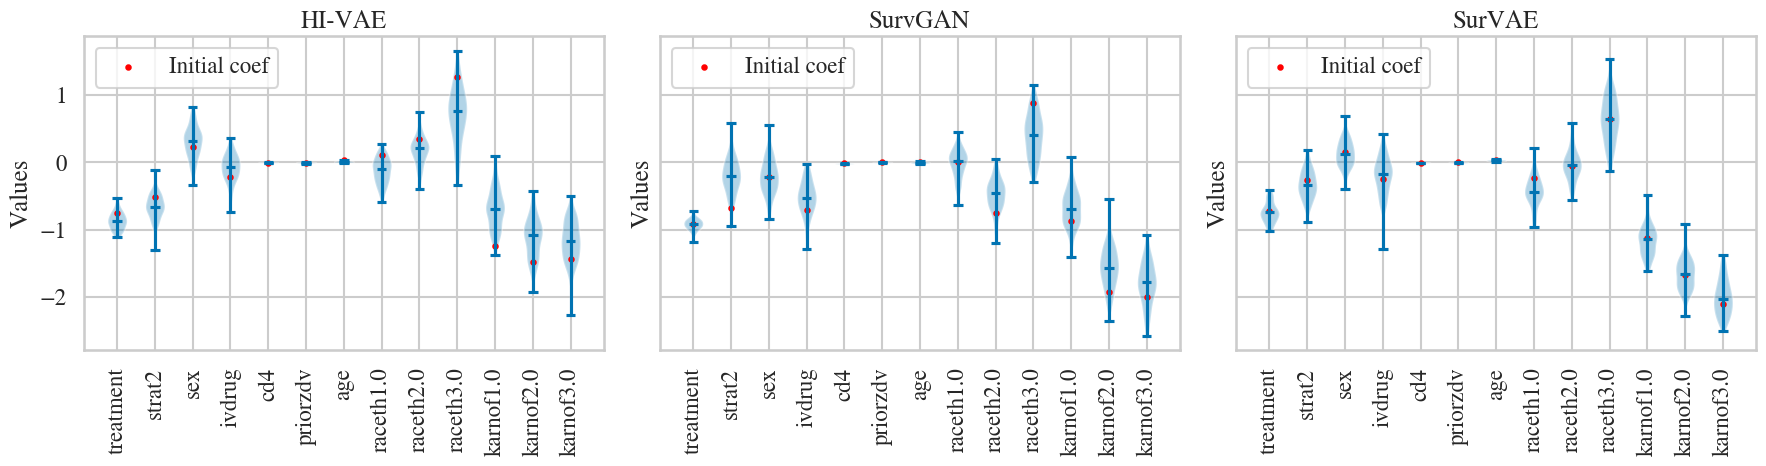

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # 3 subplots side by side

coef_treat_list = [coef_treat_hivae, coef_treat_survgan, coef_treat_survae]   
initial_coefs = [cox_generated_hivae.coef_[:], cox_generated_survgan.coef_[:], cox_generated_survae.coef_[:]] 
titles = ["HI-VAE", "SurvGAN", "SurVAE"]

for i, ax in enumerate(axs):
    parts = ax.violinplot(coef_treat_list[i], showmeans=False, showmedians=True)
    x_positions = 1 + np.arange(coef_treat_list[i].shape[1])
    y_values = initial_coefs[i]
    
    ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(df_transformed_all_oh.columns[2:], rotation=90)
    ax.set_title(titles[i])
    ax.set_ylabel("Values")
    ax.legend()

plt.tight_layout()
plt.show()

 - #### Log rank test

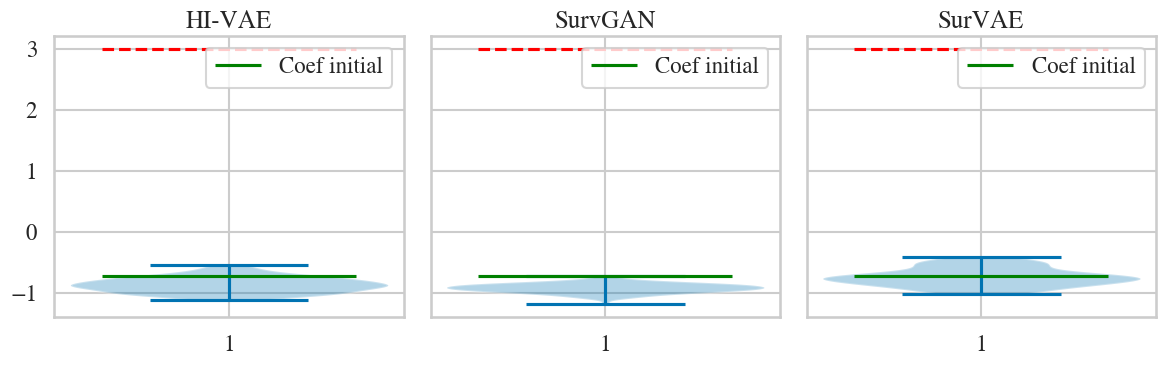

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, ax in enumerate(axs):
    ax.violinplot(coef_treat_list[i][:, 0])   
    ax.hlines(y_values[0], 0.8, 1.2, color='green', label='Coef initial')
    ax.hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='')
    ax.set_title(titles[i])
    ax.set_xticks([1])
    # ax.set_xticklabels(["Treatment"])
    # ax.set_ylabel("Coefficient Value")
    ax.legend()

plt.tight_layout()
plt.show()

- #### Test coefficient traitement (Cox)

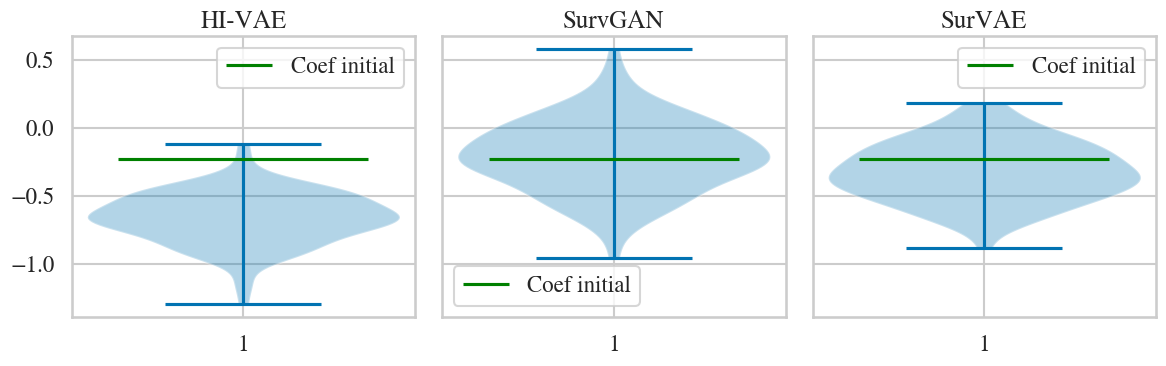

In [72]:
number_column_treatment = 0

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, ax in enumerate(axs):
    ax.violinplot(coef_treat_list[i][:, number_column_treatment+1])
    ax.hlines(y_values[7], 0.8, 1.2, color='green', label='Coef initial')
    ax.set_title(titles[i])
    ax.set_xticks([1])
    # ax.set_ylabel("Coefficient Value")
    ax.legend()

plt.tight_layout()
plt.show()

### Stratified w.r. CD4 count analysis

In [73]:
cd4_threshold = 50
df_transformed_all_oh_lowcd4 = df_transformed_all_oh[df_transformed_all_oh['cd4'] <= cd4_threshold]
print(df_transformed_all_oh_lowcd4.shape)
X_initial_lowcd4 = df_transformed_all_oh_lowcd4.to_numpy()[:,2:15]
Y_initial_lowcd4 = Surv.from_arrays(df_transformed_all_oh_lowcd4.to_numpy()[:,1]==1, df_transformed_all_oh_lowcd4.to_numpy()[:,0]) 
df_transformed_all_oh_highcd4 = df_transformed_all_oh[df_transformed_all_oh['cd4'] > cd4_threshold]
print(df_transformed_all_oh_highcd4.shape)
X_initial_highcd4 = df_transformed_all_oh_highcd4.to_numpy()[:,2:15]
Y_initial_highcd4 = Surv.from_arrays(df_transformed_all_oh_highcd4.to_numpy()[:,1]==1, df_transformed_all_oh_highcd4.to_numpy()[:,0]) 

(459, 15)
(692, 15)


In [74]:
cox_initial_lowcd4 = CoxPHSurvivalAnalysis()
cox_initial_lowcd4.fit(X_initial_lowcd4,Y_initial_lowcd4)
cox_initial_highcd4 = CoxPHSurvivalAnalysis()
cox_initial_highcd4.fit(X_initial_highcd4,Y_initial_highcd4)

CoxPHSurvivalAnalysis()

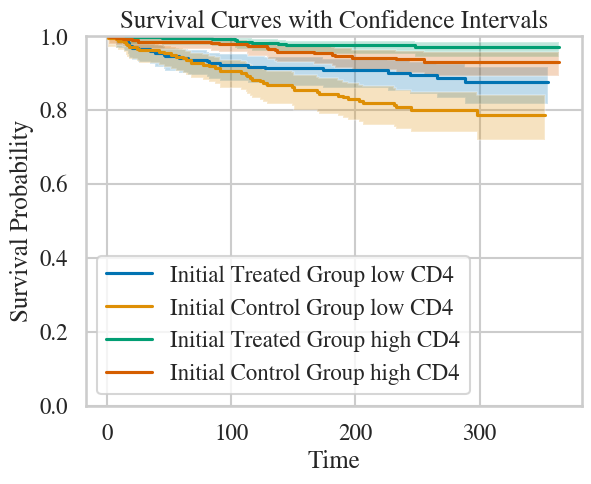

In [75]:
time_initial_lowcd4_T, survival_prob_initial_lowcd4_T, conf_int_initial_lowcd4_T = kaplan_meier_estimator(
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==1].to_numpy()[:,0], conf_type="log-log")

time_initial_lowcd4_C, survival_prob_initial_lowcd4_C, conf_int_initial_lowcd4_C = kaplan_meier_estimator(
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==0].to_numpy()[:,0], conf_type="log-log")

time_initial_highcd4_T, survival_prob_initial_highcd4_T, conf_int_initial_highcd4_T = kaplan_meier_estimator(
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==1].to_numpy()[:,0], conf_type="log-log")

time_initial_highcd4_C, survival_prob_initial_highcd4_C, conf_int_initial_highcd4_C = kaplan_meier_estimator(
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==0].to_numpy()[:,0], conf_type="log-log")

plt.step(time_initial_lowcd4_T, survival_prob_initial_lowcd4_T, where="post", label="Initial Treated Group low CD4")
plt.fill_between(time_initial_lowcd4_T, conf_int_initial_lowcd4_T[0], conf_int_initial_lowcd4_T[1], alpha=0.25, step="post")
plt.step(time_initial_lowcd4_C, survival_prob_initial_lowcd4_C, where="post", label="Initial Control Group low CD4")
plt.fill_between(time_initial_lowcd4_C, conf_int_initial_lowcd4_C[0], conf_int_initial_lowcd4_C[1], alpha=0.25, step="post")
plt.step(time_initial_highcd4_T, survival_prob_initial_highcd4_T, where="post", label="Initial Treated Group high CD4")
plt.fill_between(time_initial_highcd4_T, conf_int_initial_highcd4_T[0], conf_int_initial_highcd4_T[1], alpha=0.25, step="post")
plt.step(time_initial_highcd4_C, survival_prob_initial_highcd4_C, where="post", label="Initial Control Group high CD4")
plt.fill_between(time_initial_highcd4_C, conf_int_initial_highcd4_C[0], conf_int_initial_highcd4_C[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")
plt.show()

In [76]:
print('Initial low cd4:', compare_survival(Y_initial_lowcd4, X_initial_lowcd4[:,number_column_treatment]))
print('Initial high cd4:', compare_survival(Y_initial_highcd4, X_initial_highcd4[:,number_column_treatment]))

Initial low cd4: (np.float64(5.535873093721627), np.float64(0.018630467405504756))
Initial high cd4: (np.float64(4.395519026726351), np.float64(0.03603349014270788))


In [77]:
def compute_cox_generated_cd4(est_data_gen_transformed, cox_init):
    n_generated_sample = len(est_data_gen_transformed)
    coef_treat_lowcd4 = np.zeros((n_generated_sample, cox_init.coef_.shape[0] + 1))
    coef_treat_highcd4 = np.zeros((n_generated_sample, cox_init.coef_.shape[0] + 1))
    for i in np.arange(n_generated_sample):
        #print(i)
        df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=aids_control_columns)
        df_transformed_generated['treatment'] = 0
        df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
        df_transformed_T_Cgen = df_transformed_T_Cgen.reindex(columns=['time', 'censor' , 'treatment','strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4', 'priorzdv', 'age'])
        df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
        for feat in categorical_encode:
            df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
        
        df_transformed_T_Cgen_oh_lowcd4 = df_transformed_T_Cgen_oh[df_transformed_T_Cgen_oh['cd4'] <= cd4_threshold]
        X_gen_lowcd4 = df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,2:15]
        Y_gen_lowcd4 = Surv.from_arrays(df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,0]) 
        df_transformed_T_Cgen_oh_highcd4 = df_transformed_T_Cgen_oh[df_transformed_T_Cgen_oh['cd4'] > cd4_threshold]
        X_gen_highcd4 = df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,2:15]
        Y_gen_highcd4 = Surv.from_arrays(df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,0]) 
        
        coef_treat_lowcd4[i,0] = -np.log(compare_survival(Y_gen_lowcd4,X_gen_lowcd4[:,number_column_treatment])[1])
        cox_generated_lowcd4 = CoxPHSurvivalAnalysis()
        cox_generated_lowcd4.fit(X_gen_lowcd4,Y_gen_lowcd4)
        coef_treat_lowcd4[i,1:] = cox_generated_lowcd4.coef_[:]

        coef_treat_highcd4[i,0] = -np.log(compare_survival(Y_gen_highcd4,X_gen_highcd4[:,number_column_treatment])[1])
        cox_generated_highcd4 = CoxPHSurvivalAnalysis()
        cox_generated_highcd4.fit(X_gen_highcd4,Y_gen_highcd4)
        coef_treat_highcd4[i,1:] = cox_generated_highcd4.coef_[:]

    res_lowcd4 = [coef_treat_lowcd4, X_gen_lowcd4, Y_gen_lowcd4]
    res_highcd4 = [coef_treat_highcd4, X_gen_highcd4, Y_gen_highcd4]
    return res_lowcd4, res_highcd4

In [78]:
res_lowcd4_hivae, res_highcd4_hivae = compute_cox_generated_cd4(est_data_gen_transformed_hivae, cox_initial)
res_lowcd4_survgan, res_highcd4_survgan = compute_cox_generated_cd4(est_data_gen_transformed_survgan, cox_initial)
res_lowcd4_survae, res_highcd4_survae = compute_cox_generated_cd4(est_data_gen_transformed_survae, cox_initial)

coef_treat_lowcd4 = [res_lowcd4_hivae[0], res_lowcd4_survgan[0], res_lowcd4_survae[0]]
X_gen_lowcd4 = [res_lowcd4_hivae[1], res_lowcd4_survgan[1], res_lowcd4_survae[1]]
Y_gen_lowcd4 = [res_lowcd4_hivae[2], res_lowcd4_survgan[2], res_lowcd4_survae[2]]
coef_treat_highcd4 = [res_highcd4_hivae[0], res_highcd4_survgan[0], res_highcd4_survae[0]]
X_gen_highcd4 = [res_highcd4_hivae[1], res_highcd4_survgan[1], res_highcd4_survae[1]]
Y_gen_highcd4 = [res_highcd4_hivae[2], res_highcd4_survgan[2], res_highcd4_survae[2]]

In [79]:
titles = ["HI-VAE", "SurvGAN", "SurVAE"]
for i in range(3):
    print(titles[i] + ' low cd4:', compare_survival(Y_gen_lowcd4[i], X_gen_lowcd4[i][:,number_column_treatment]))
    print(titles[i] + ' high cd4:', compare_survival(Y_gen_highcd4[i], X_gen_highcd4[i][:,number_column_treatment]))
    print('\n')

HI-VAE low cd4: (np.float64(0.8670256929112382), np.float64(0.35178004068915536))
HI-VAE high cd4: (np.float64(13.231677254264293), np.float64(0.0002752573918640461))


SurvGAN low cd4: (np.float64(8.814469494364584), np.float64(0.0029885108672162695))
SurvGAN high cd4: (np.float64(0.015819383214149902), np.float64(0.899909929150024))


SurVAE low cd4: (np.float64(0.1321603057125017), np.float64(0.7162025919413825))
SurVAE high cd4: (np.float64(5.3584791227806505), np.float64(0.02062175030283829))




In [80]:
xtick_labels = ['LR','strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
                'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0',
                'karnof1.0', 'karnof2.0', 'karnof3.0']

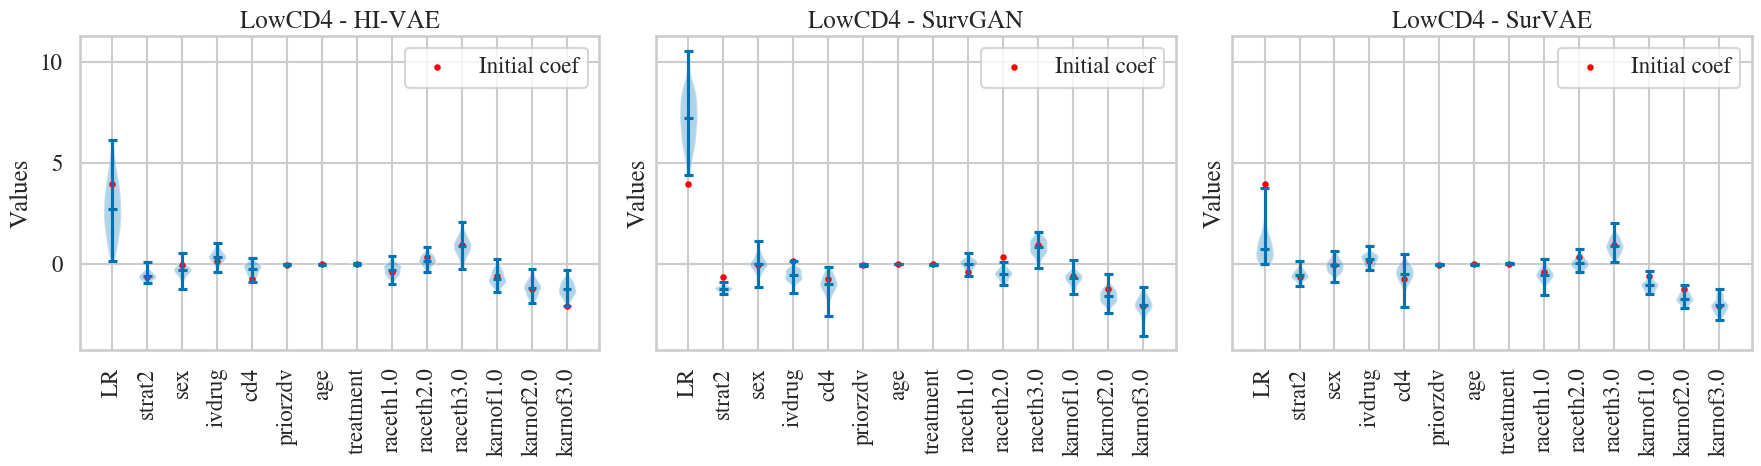

In [81]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
titles = ["LowCD4 - HI-VAE", "LowCD4 - SurvGAN", "LowCD4 - SurVAE"]

# number_column_treatment = 7  
for i, ax in enumerate(axs):
    ax.violinplot(coef_treat_lowcd4[i], showmeans=False, showmedians=True)

    y_values = np.zeros(coef_treat_lowcd4[i].shape[1])
    y_values[0] = -np.log(compare_survival(Y_initial_lowcd4, X_initial_lowcd4[:, number_column_treatment])[1])
    y_values[1:] = cox_initial_lowcd4.coef_[:]
    x_positions = 1 + np.arange(coef_treat_lowcd4[i].shape[1])
    ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

    ax.set_xticks(x_positions)
    ax.set_xticklabels(xtick_labels, rotation=90)
    ax.set_title(titles[i])
    ax.set_ylabel("Values")
    ax.legend()

plt.tight_layout()
plt.show()

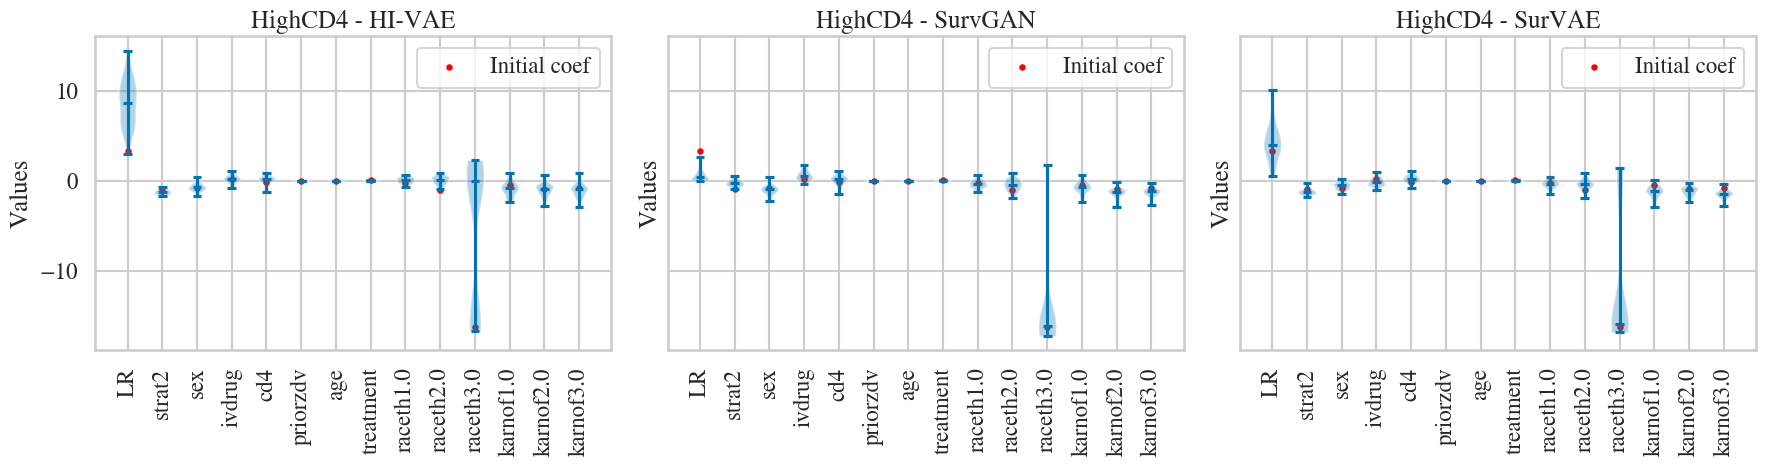

In [82]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
titles = ["HighCD4 - HI-VAE", "HighCD4 - SurvGAN", "HighCD4 - SurVAE"]

# number_column_treatment = 7  
for i, ax in enumerate(axs):
    ax.violinplot(coef_treat_highcd4[i], showmeans=False, showmedians=True)

    y_values = np.zeros(coef_treat_highcd4[i].shape[1])
    y_values[0] = -np.log(compare_survival(Y_initial_highcd4, X_initial_highcd4[:, number_column_treatment])[1])
    y_values[1:] = cox_initial_highcd4.coef_[:]
    x_positions = 1 + np.arange(coef_treat_highcd4[i].shape[1])
    ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

    ax.set_xticks(x_positions)
    ax.set_xticklabels(xtick_labels, rotation=90)
    ax.set_title(titles[i])
    ax.set_ylabel("Values")
    ax.legend()

plt.tight_layout()
plt.show()